In [1]:
# Essential libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np
import random


In [2]:
# Libraries for machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
import xgboost as xgb


In [3]:
# Libraries for deep learning models (Neural Networks)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [4]:
# Libraries for visualization
import matplotlib.pyplot as plt


In [5]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Step 1 & 2: Load the datasets


In [ ]:
# Load the train_labels data
#train_labels = pd.read_csv('train_labels.csv')


# Step 3 &4: Read the dataset and select 20% of the observations from train_labels data, then merge with "train" data

Read Data in Chunks:

Use chunking to read large datasets incrementally to avoid memory issues.
Random Sampling:

Select 20% of observations randomly from train_labels.csv for a smaller, manageable dataset.
Merge Sample with Train Data:

Merge the 20% sample with corresponding rows from train_data.csv using an inner join.
Save Development Sample:

Store the merged dataset as development_sample.csv for future use, avoiding the need to read the large files again.





In [ ]:
## sampled_labels = train_labels.sample(frac=0.2, random_state=42) 

In [ ]:
# Chunksize read train_data.csv in chunks and merge with the sampled labels
chunksize = 400000  # Number of rows to read per chunk
sampled_data = []   # List to store each merged chunk

# Loop over the train_data.csv file in chunks
##for chunk in pd.read_csv("train_data.csv", chunksize=chunksize):
    # Merge the current chunk with the sampled labels based on 'customer_ID'
##    merged_chunk = pd.merge(chunk, sampled_labels, on='customer_ID', how='inner')
    
    # Append the merged chunk to the list
##    sampled_data.append(merged_chunk)


In [ ]:
# Combine all the processed chunks into a single DataFrame
##final_sample = pd.concat(sampled_data, ignore_index=True)

# Save the final development sample to a CSV file
#final_sample.to_csv("development_sample.csv", index=False) ## (already saved)

# Print the shape of the final sample
##final_sample.shape

In [6]:
## Loading my files
final_sample = pd.read_csv('development_sample.csv')

In [409]:
final_sample.shape

(1107069, 192)

In [410]:
final_sample.dtypes.value_counts()

float64           185
object              3
int64               3
datetime64[ns]      1
Name: count, dtype: int64

# STEP 5: Perform One-Hot encoding on categorical variables
What to Do:

Identify categorical variables (columns with type object).

Apply One-Hot Encoding to convert these categorical variables into binary columns (0s and 1s).

Ensure that the newly created columns are properly added to the dataset, and the original categorical columns are removed.


In [417]:
# Display columns that have 'object' data type
object_columns = final_sample.select_dtypes(include=['object']).columns
object_columns

Index(['customer_ID', 'D_63', 'D_64'], dtype='object')

In [12]:
# STEP 5: Encoding
# Perform One-Hot Encoding on 'D_63' and 'D_64' with dummy_na=True to handle missing values
dev_sample_encoded = pd.get_dummies(final_sample, columns=['D_63', 'D_64'], dummy_na=True, dtype=int)


In [414]:
dev_sample_encoded.shape

(1107069, 201)

In [421]:
print("Unique values in D_63:", final_sample['D_63'].unique())
print("\nUnique values in D_64:", final_sample['D_64'].unique())

Unique values in D_63: ['XZ' 'CO' 'CL' 'CR' 'XM' 'XL']

Unique values in D_64: [nan 'O' '-1' 'R' 'U']


In [415]:
dev_sample_encoded.dtypes.value_counts()

float64           185
int32              12
int64               2
object              1
datetime64[ns]      1
Name: count, dtype: int64

# STEP 6: Aggregation

For Numerical Features:

    Create new features by aggregating the historical data for each customer over different time periods (e.g., 3, 6, 9, 12 months).

     Use various aggregation methods like average, sum, minimum, maximum.

     Include the most recent value (April 2018) as a separate feature.
      Create trend features (e.g., year-over-year change).


For Categorical Features (which are now binary due to one-hot encoding):

    Create response rate features over different time periods.

    Create binary features indicating if a category was ever present in a given time period.
    Include the most recent value (April 2018).


Handle varying amounts of historical data:

   Some customers may have less than 13 months of data, so aggregations should adapt to the available data for each customer.

In [22]:
# Ensure 'S_2' is in datetime format
dev_sample_encoded['S_2'] = pd.to_datetime(dev_sample_encoded['S_2'])
dev_sample_encoded.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_63_nan,D_64_-1,D_64_O,D_64_R,D_64_U,D_64_nan
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-03-11,0.374606,0.033519,0.044293,1.008622,0.001470,0.459235,0.002339,0.006168,...,0,0,0,0,0,0,0,0,0,1
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-04-22,0.414269,0.002516,0.059667,0.123964,0.004374,0.434148,0.001405,0.052130,...,0,0,0,0,0,0,0,0,0,1
2,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-05-12,0.413310,0.003285,0.053418,0.304955,0.002316,0.415906,0.009388,0.048780,...,0,0,0,0,0,0,0,1,0,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-06-10,0.328983,0.038574,0.049463,0.115654,0.004654,0.416112,0.003223,0.081001,...,0,0,0,0,0,0,0,1,0,0
4,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-07-19,0.496989,0.005552,0.041452,0.133631,0.007363,0.419864,0.003393,0.098308,...,0,0,0,0,0,0,0,1,0,0


In [19]:
import pandas as pd
import numpy as np

# Our dataframe is named dev_sample_encoded
df = dev_sample_encoded

# List of numerical features
numerical_features = ['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43', 'D_44', 'B_4', 'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'D_49', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51', 'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'D_53', 'S_5',
                      'B_11', 'S_6', 'D_54', 'R_4', 'S_7', 'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60', 'D_61', 'B_15', 'S_11', 'D_62', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'D_66', 'B_20', 'D_68', 'S_12', 'R_6',
                      'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'D_73', 'P_4', 'D_74', 'D_75', 'D_76', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'S_19', 'R_19', 'B_32', 'S_20', 'R_20', 'R_21', 'B_33',
                      'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_24', 'R_25', 'D_96', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106', 'D_107', 'B_36', 'B_37', 'R_26', 'R_27', 'B_38', 'D_108', 'D_109']

# List of binary features
binary_features = ['D_63_CL', 'D_63_CO', 'D_63_CR', 'D_63_XL', 'D_63_XM', 'D_63_XZ', 'D_63_nan', 'D_64_-1', 'D_64_O',
                   'D_64_R', 'D_64_U', 'D_64_nan']


In [20]:
def aggregate_numerical(df, feature):
    # 6-month average (assuming about 30 observations per month)
    df[f'{feature}_Ave_6'] = df.groupby('customer_ID')[feature].transform(
        lambda x: x.rolling(window=180, min_periods=1).mean())
    
    # Most recent value
    df[f'{feature}_Apr_2018'] = df.groupby('customer_ID')[feature].transform('last')
    
    return df

def aggregate_binary(df, feature):
    # 6-month response rate (assuming about 30 observations per month)
    df[f'{feature}_Response_Rate_6'] = df.groupby('customer_ID')[feature].transform(
        lambda x: x.rolling(window=180, min_periods=1).mean())
    
    # Ever response in the entire period
    df[f'{feature}_Ever_Response'] = df.groupby('customer_ID')[feature].transform('max')
    
    return df

In [21]:

# Sort the dataframe (S_2 is already in datetime format)
df = df.sort_values(['customer_ID', 'S_2'])

# Apply aggregations
for feature in numerical_features:
    df = aggregate_numerical(df, feature)

for feature in binary_features:
    df = aggregate_binary(df, feature)

# Keep only the last record for each customer
df_final = df.groupby('customer_ID').last().reset_index()

# The resulting df_final dataframe now contains the original features
# plus the new aggregated features for each customer



C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Apr_2018'] = df.groupby('customer_ID')[feature].transform('last')
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Ave_6'] = df.groupby('customer_ID')[feature].transform(
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Apr_2018'] = df.groupby('customer_ID')[feature].transform('last')
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Ave_6'] = df.groupby('customer_ID')[feature].transform(
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Apr_2018'] = df.groupby('customer_ID')[feature].transform('last')
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Ave_6'] = df.groupby('customer_ID')[feature].transform(
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Apr_2018'] = df.groupby('customer_ID')[feature].transform('last')
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Ave_6'] = df.groupby('customer_ID')[feature].transform(
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Apr_2018'] = df.groupby('customer_ID')[feature].transform('last')
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Ave_6'] = df.groupby('customer_ID')[feature].transform(
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Apr_2018'] = df.groupby('customer_ID')[feature].transform('last')
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Ave_6'] = df.groupby('customer_ID')[feature].transform(
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Apr_2018'] = df.groupby('customer_ID')[feature].transform('last')
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Ave_6'] = df.groupby('customer_ID')[feature].transform(
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Apr_2018'] = df.groupby('customer_ID')[feature].transform('last')
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Response_Rate_6'] = df.groupby('customer_ID')[feature].transform(
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resu

C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Ever_Response'] = df.groupby('customer_ID')[feature].transform('max')
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_Response_Rate_6'] = df.groupby('customer_ID')[feature].transform(
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3034237201.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

Shape of final dataframe: (91782, 461)
New features created: 0


In [23]:
# the number of rows created
print(f"Shape of final dataframe: {df_final.shape}")
print(f"New features created: {df_final.shape[1] - dev_sample_encoded.shape[1]}")

Shape of final dataframe: (91782, 461)
New features created: 260


In [24]:
# Randomly sample 50,000 rows
Small_sample = df_final.sample(n=10000, random_state=42)

# Save the sampled dataframe as a CSV file
Small_sample.to_csv('Step_6_sample_50k_1.csv', index=False)

In [252]:
df_final.shape

(91782, 461)

In [416]:
df_final.dtypes.value_counts()

float64           433
int32              24
int64               2
object              1
datetime64[ns]      1
Name: count, dtype: int64

# STEP 7: Split data into 70% as Train sample, 15% as Test1, and 15% as Test2

What to Do:

Split the dataset into:

70% for the Train sample.
15% for Test1.
15% for Test2.
Ensure the target variable is split correctly along with the features (i.e., X_train, Y_train, etc.).

Purpose:

Train sample: Used for model training.
Test1 and Test2: Used for model evaluation to measure generalization.


In [267]:
# STEP 7: Split Dataset
from sklearn.model_selection import train_test_split

# Step 1: Define the target variable (Y) and input features (X)
Y = df_final['target']  # Target variable
X = df_final.drop(columns=['target', 'customer_ID', 'S_2'])  # Drop unnecessary columns

# First split - Train (70%) and Remaining (30%)
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)

# Second split - Split the remaining 30% into Test1 (15%) and Test2 (15%)
X_test_1, X_test_2, Y_test_1, Y_test_2 = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp
)


In [278]:
X_train_F = X_train
X_test_1_F = X_test_1
X_test_2_F = X_test_2

(64247, 458)

In [83]:
# Step 4: Print the shape of each dataset to confirm the splits
print(f"Train Sample: X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"Test1 Sample: X_test_1: {X_test_1.shape}, Y_test_1: {Y_test_1.shape}")
print(f"Test2 Sample: X_test_2: {X_test_2.shape}, Y_test_2: {Y_test_2.shape}")


Train Sample: X_train: (64247, 458), Y_train: (64247,)
Test1 Sample: X_test_1: (13767, 458), Y_test_1: (13767,)
Test2 Sample: X_test_2: (13768, 458), Y_test_2: (13768,)


# Step 8: Feature Selection Using XGBoost and Feature Importance Analysis
1) Building two XGBoost models to determine which features have high predictive power.
2) Keeping only the features that have a feature importance score greater than 0.5% from either of the two models.
3) Saving the feature importance scores as CSV files for reference and future use.

--> Details:

Model 1: XGBoost with default parameters.
Model 2: XGBoost with custom parameters:
300 trees (estimators)
Learning rate = 0.5
Max depth = 4

50% of observations per tree (subsample).

50% of features per tree (colsample_bytree).

Class weight: Assign weight 5 to default observations (positive class).




Summary:
Trained both models with all features and extracted feature importances.

Filtered features with importance > 0.5%.

Re-trained the models with only the selected features.

Saved the final models correctly to ensure the feature alignment.

In [30]:
from xgboost import XGBClassifier
import pandas as pd
import numpy as np


In [292]:
# Ensure NaNs are consistent across all datasets
X_train_F = X_train_F.replace(np.nan, np.NaN)
X_test_1_F = X_test_1_F.replace(np.nan, np.NaN)
X_test_2_F = X_test_2_F.replace(np.nan, np.NaN)

print("NaN values replaced across all datasets.")


NaN values replaced across all datasets.


In [293]:
# Prepare the train data (X_train, y_train) for XGBoost
#Drop unnecessary columns
X_train_F = X_train_F.drop(columns=['customer_ID', 'S_2'], errors='ignore')
X_test_1_F = X_test_1_F.drop(columns=['customer_ID', 'S_2'], errors='ignore')
X_test_2_F = X_test_2_F.drop(columns=['customer_ID', 'S_2'], errors='ignore')

In [294]:
# Train XGB with default parameters
xgb_default = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_default.fit(X_train_F, Y_train)

C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:29:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [34]:
# Extract features with feature importance highter thatn 0.005
importance_default = pd.DataFrame({
    'Feature': X_train.columns,
    'Feature_Importance': xgb_default.feature_importances_
})

# Filter features with importance > 0.5%
filtered_importance = importance_default[importance_default['Feature_Importance'] > 0.005]

# Save filtered features to CSV
filtered_importance.to_csv('important_features_default.csv', index=False)


In [41]:
filtered_importance.shape

(20, 2)

In [295]:
# Train XGB with custom parameters
xgb_custom = XGBClassifier(
    n_estimators=300,
    learning_rate=0.5,
    max_depth=4,
    subsample=0.5,
    colsample_bytree=0.5,
    scale_pos_weight=5,
    use_label_encoder=False,
    eval_metric='logloss'
)

xgb_custom.fit(X_train_F, Y_train)


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:30:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.5, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [42]:
# Extract feature importance from the custom XGB model
importance_custom = pd.DataFrame({
    'Feature': X_train_F.columns,
    'Feature_Importance': xgb_custom.feature_importances_
})

# Filter features with importance > 0.5%
filtered_importance_custom = importance_custom[importance_custom['Feature_Importance'] > 0.005]

# Save the filtered features to CSV
filtered_importance_custom.to_csv('important_features_custom.csv', index=False)


In [43]:
filtered_importance_custom.shape

(13, 2)

In [44]:
# Load both feature importance files with the correct headers
important_features_default = pd.read_csv('important_features_default.csv')
important_features_custom = pd.read_csv('important_features_custom.csv')



In [45]:
# Combine the two feature sets
combined_features = pd.concat([important_features_default, important_features_custom], ignore_index=True)


In [46]:
combined_features.shape

(33, 2)

In [47]:
# Drop duplicate features, keeping the one with the highest importance
combined_features = combined_features.sort_values(by='Feature_Importance', ascending=False)
combined_features = combined_features.drop_duplicates(subset='Feature', keep='first')


In [48]:
combined_features.shape

(27, 2)

In [49]:
# Save the combined filtered features to CSV with proper headers
combined_features.to_csv('combined_features.csv', index=False)


In [50]:
# Extract the final list of selected features
selected_features = combined_features['Feature'].tolist()


In [139]:
selected_features

['P_2',
 'B_1',
 'D_48',
 'B_37_Apr_2018',
 'B_2',
 'P_2_Ave_6',
 'B_23',
 'B_9',
 'B_11',
 'B_2_Apr_2018',
 'D_42_Ave_6',
 'B_7_Apr_2018',
 'R_1',
 'D_64_O',
 'R_1_Ave_6',
 'R_2',
 'D_41',
 'D_44',
 'D_39',
 'S_3_Ave_6',
 'B_3',
 'D_44_Ave_6',
 'D_50',
 'D_49',
 'D_43_Ave_6',
 'D_49_Apr_2018',
 'D_42']

In [86]:
# Let's save a copy of the train and test data with only our selected features.
# Filter the datasets with the selected features
X_train_filtered = X_train[selected_features]
X_test_1_filtered = X_test_1[selected_features]
X_test_2_filtered = X_test_2[selected_features]


In [283]:
X_train = X_train_filtered
X_test_1 = X_test_1_filtered
X_test_2 = X_test_2_filtered

In [423]:
X_test_2.shape

(13768, 27)

In [285]:
X_train.shape

(64247, 27)

In [56]:

# Save the filtered X_ datasets
##X_train_filtered.to_csv('X_train_filtered.csv', index=False)
##X_test_1_filtered.to_csv('X_test_1_filtered.csv', index=False)
##X_test_2_filtered.to_csv('X_test_2_filtered.csv', index=False)

# Save the corresponding Y_ datasets (target variables)
##Y_train.to_csv('Y_train.csv', index=False)
###Y_test_1.to_csv('Y_test_1.csv', index=False)
##Y_test_2.to_csv('Y_test_2.csv', index=False)


In [286]:
Y_test_1.shape

(13767,)

In [287]:
Y_test_2.shape

(13768,)

In [71]:
import pandas as pd
# Let's load our saved data back
# Load filtered X_ datasets
##X_train_filtered = pd.read_csv('X_train_filtered.csv')
##X_test_1_filtered = pd.read_csv('X_test_1_filtered.csv')
##X_test_2_filtered = pd.read_csv('X_test_2_filtered.csv')

# Load Y_ datasets and convert to Series
##Y_train = pd.read_csv('Y_train.csv', header=None).squeeze(axis=1)
##Y_test_1 = pd.read_csv('Y_test_1.csv', header=None).squeeze(axis=1)
##Y_test_2 = pd.read_csv('Y_test_2.csv', header=None).squeeze(axis=1)


In [91]:
Y_train

1362     0
4706     0
30994    1
90789    1
43142    1
        ..
14007    0
37876    0
91319    1
69666    0
78872    0
Name: target, Length: 64247, dtype: int64

In [92]:
print(Y_train.unique())  # Inspect unique values in Y_train


[0 1]


  # Retrain the XGBoost models (default and custom)


In [93]:
# Default XGB Model
xgb_default = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_default.fit(X_train, Y_train)

C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:30:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [95]:
# Saved the default model
import joblib
joblib.dump(xgb_default, 'xgb_default_filtered.joblib')

['xgb_default_filtered.joblib']

In [94]:
# Custom XGB Model
xgb_custom = XGBClassifier(n_estimators=300, learning_rate=0.5, max_depth=4, 
                           subsample=0.5, colsample_bytree=0.5, scale_pos_weight=5)
xgb_custom.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [96]:
# Saved the custom model
import joblib
joblib.dump(xgb_custom, 'xgb_custom_filtered.joblib')

['xgb_custom_filtered.joblib']

# Step 9: Goal: Run a grid search using different combinations of hyperparameters for the XGBoost model.


--> Evaluate each model using the AUC (Area Under Curve) metric on the Train, Test1, and Test2 datasets.

--> Store the results in a table (as shown in the image) and save the table after each iteration to avoid losing data if anything fails mid-way


# Grid Search Combinations:
We need to test all combinations of the following hyperparameters:

Number of Trees (n_estimators): 50, 100, 300 (3)

Learning Rate (learning_rate): 0.01, 0.1 (2)

Subsample (subsample): 50%, 80% (2)

Percentage of Features per Tree (colsample_bytree): 50%, 100% (2)

Weight of Default Observations (scale_pos_weight): 1, 5, 10 (3)

This results in a grid with: 3
×
2
×
2
×
2
×
3
=
72
3×2×2×2×3=72 possible combinations.


In [97]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import roc_auc_score

# Step 1: Define the hyperparameter grid
n_estimators = [50, 100, 300]
learning_rates = [0.01, 0.1]
subsamples = [0.5, 0.8]
colsample_bytrees = [0.5, 1.0]
weights = [1, 5, 10]

In [98]:
# Initialize an empty DataFrame to store the results
results = pd.DataFrame(columns=['# Trees', 'LR', 'Subsample', '% Features', 
                                'Weight of Default', 'AUC Train', 'AUC Test 1', 'AUC Test 2'])


In [99]:
# Loop over all parameter combinations 

# Initialize an empty list to store the results
results_list = []

# Step 3: Loop over all parameter combinations
for n in n_estimators:
    for lr in learning_rates:
        for subsample in subsamples:
            for colsample in colsample_bytrees:
                for weight in weights:
                    # Train the XGBoost model with the current combination
                    model = xgb.XGBClassifier(
                        n_estimators=n,
                        learning_rate=lr,
                        subsample=subsample,
                        colsample_bytree=colsample,
                        scale_pos_weight=weight,
                        use_label_encoder=False,
                        eval_metric='logloss'
                    )

                    # Fit the model on the train data
                    model.fit(X_train, Y_train)

                    # Calculate AUC for Train, Test1, and Test2 datasets
                    auc_train = roc_auc_score(Y_train, model.predict_proba(X_train)[:, 1])
                    auc_test1 = roc_auc_score(Y_test_1, model.predict_proba(X_test_1)[:, 1])
                    auc_test2 = roc_auc_score(Y_test_2, model.predict_proba(X_test_2)[:, 1])

                    # Store the results as a dictionary in the results_list
                    results_list.append({
                        '# Trees': n,
                        'LR': lr,
                        'Subsample': subsample,
                        '% Features': colsample,
                        'Weight of Default': weight,
                        'AUC Train': auc_train,
                        'AUC Test 1': auc_test1,
                        'AUC Test 2': auc_test2
                    })

                    # Print progress
                    print(f"Completed: Trees={n}, LR={lr}, Subsample={subsample}, "
                          f"Features={colsample}, Weight={weight}")

# Step 4: Convert the results list into a DataFrame
results = pd.DataFrame(results_list)


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.01, Subsample=0.5, Features=0.5, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.01, Subsample=0.5, Features=0.5, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.01, Subsample=0.5, Features=0.5, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.01, Subsample=0.5, Features=1.0, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.01, Subsample=0.5, Features=1.0, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.01, Subsample=0.5, Features=1.0, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.01, Subsample=0.8, Features=0.5, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.01, Subsample=0.8, Features=0.5, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.01, Subsample=0.8, Features=0.5, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.01, Subsample=0.8, Features=1.0, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.01, Subsample=0.8, Features=1.0, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.01, Subsample=0.8, Features=1.0, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.1, Subsample=0.5, Features=0.5, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.1, Subsample=0.5, Features=0.5, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.1, Subsample=0.5, Features=0.5, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.1, Subsample=0.5, Features=1.0, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.1, Subsample=0.5, Features=1.0, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.1, Subsample=0.5, Features=1.0, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.1, Subsample=0.8, Features=0.5, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.1, Subsample=0.8, Features=0.5, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.1, Subsample=0.8, Features=0.5, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.1, Subsample=0.8, Features=1.0, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.1, Subsample=0.8, Features=1.0, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=50, LR=0.1, Subsample=0.8, Features=1.0, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.01, Subsample=0.5, Features=0.5, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.01, Subsample=0.5, Features=0.5, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.01, Subsample=0.5, Features=0.5, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.01, Subsample=0.5, Features=1.0, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.01, Subsample=0.5, Features=1.0, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.01, Subsample=0.5, Features=1.0, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.01, Subsample=0.8, Features=0.5, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.01, Subsample=0.8, Features=0.5, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.01, Subsample=0.8, Features=0.5, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.01, Subsample=0.8, Features=1.0, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.01, Subsample=0.8, Features=1.0, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.01, Subsample=0.8, Features=1.0, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.1, Subsample=0.5, Features=0.5, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.1, Subsample=0.5, Features=0.5, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.1, Subsample=0.5, Features=0.5, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:44:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.1, Subsample=0.5, Features=1.0, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.1, Subsample=0.5, Features=1.0, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.1, Subsample=0.5, Features=1.0, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.1, Subsample=0.8, Features=0.5, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.1, Subsample=0.8, Features=0.5, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.1, Subsample=0.8, Features=0.5, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.1, Subsample=0.8, Features=1.0, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.1, Subsample=0.8, Features=1.0, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=100, LR=0.1, Subsample=0.8, Features=1.0, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.01, Subsample=0.5, Features=0.5, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.01, Subsample=0.5, Features=0.5, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.01, Subsample=0.5, Features=0.5, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.01, Subsample=0.5, Features=1.0, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.01, Subsample=0.5, Features=1.0, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.01, Subsample=0.5, Features=1.0, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.01, Subsample=0.8, Features=0.5, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.01, Subsample=0.8, Features=0.5, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.01, Subsample=0.8, Features=0.5, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.01, Subsample=0.8, Features=1.0, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.01, Subsample=0.8, Features=1.0, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.01, Subsample=0.8, Features=1.0, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.1, Subsample=0.5, Features=0.5, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.1, Subsample=0.5, Features=0.5, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:45:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.1, Subsample=0.5, Features=0.5, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:46:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.1, Subsample=0.5, Features=1.0, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:46:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.1, Subsample=0.5, Features=1.0, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:46:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.1, Subsample=0.5, Features=1.0, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:46:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.1, Subsample=0.8, Features=0.5, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:46:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.1, Subsample=0.8, Features=0.5, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:46:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.1, Subsample=0.8, Features=0.5, Weight=10


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:46:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.1, Subsample=0.8, Features=1.0, Weight=1


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:46:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.1, Subsample=0.8, Features=1.0, Weight=5


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:46:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Completed: Trees=300, LR=0.1, Subsample=0.8, Features=1.0, Weight=10


In [100]:

# Step 5: Save the DataFrame to a CSV file
results.to_csv('grid_search_results.csv', index=False)


In [101]:
results.shape

(72, 8)

# Step 10: Choose the Best Model Based on Bias and Variance

Goal of Step 10:

Select the best model based on the grid search results obtained from Step 9.

Look for the best balance between bias and variance using AUC scores for Train, Test1, and Test2.

High AUC on Train but low AUC on Test sets: Model might be overfitting (high variance).

Low AUC on both Train and Test sets: Model might be underfitting (high bias).

Re-train the model with the best parameters found in the grid search.

Save the final XGBoost model for future predictions.

In [328]:
import pandas as pd

# Load the grid search results from Step 9
results = pd.read_csv('grid_search_results.csv')

# Display the top rows to inspect the data
print(results.head())


   # Trees    LR  Subsample  % Features  Weight of Default  AUC Train  \
0       50  0.01        0.5         0.5                  1   0.953113   
1       50  0.01        0.5         0.5                  5   0.951193   
2       50  0.01        0.5         0.5                 10   0.950078   
3       50  0.01        0.5         1.0                  1   0.952456   
4       50  0.01        0.5         1.0                  5   0.950037   

   AUC Test 1  AUC Test 2  
0    0.949027    0.945045  
1    0.947494    0.942756  
2    0.947053    0.941889  
3    0.947578    0.943406  
4    0.946035    0.941195  


In [329]:
# Sort results by AUC on Test1 and Test2 to find the most generalizable model
best_model = results.sort_values(by=['AUC Test 1', 'AUC Test 2'], ascending=False).iloc[0]

print(f"Best Model Parameters:\n{best_model}")


Best Model Parameters:
# Trees              100.000000
LR                     0.100000
Subsample              0.500000
% Features             0.500000
Weight of Default      1.000000
AUC Train              0.967577
AUC Test 1             0.953970
AUC Test 2             0.950596
Name: 36, dtype: float64


In [105]:
import xgboost as xgb
import joblib  # For saving the model

# Step 1: Extract the best parameters dynamically from the best_model DataFrame
best_params = {
    'n_estimators': int(best_model['# Trees']),
    'learning_rate': float(best_model['LR']),
    'subsample': float(best_model['Subsample']),
    'colsample_bytree': float(best_model['% Features']),
    'scale_pos_weight': float(best_model['Weight of Default'])
}



In [106]:
# Step 2: Re-train the final XGBoost model with the best parameters
final_model = xgb.XGBClassifier(
    **best_params,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Fit the model on the training data
final_model.fit(X_train, Y_train)

# Step 3: Save the final model
joblib.dump(final_model, 'final_xgb_model.joblib')


C:\Users\mourl\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:59:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


['final_xgb_model.joblib']

# Step 11: Grid Search for Neural Network: Processing the data

Overview of Step 11:

The goal here is to train a Neural Network model using grid search to find the best hyperparameters. However, before we can run 

the grid search, we need to process the data to make it suitable for the neural network.

Use only the features selected in Step 10:

Preprocessing Steps:

Grid Search for Neural Network:

Store Results in a Table:
 --> Like in Step 9, create a table to store AUC scores for Train, Test1, and Test2 for each combination.

In [107]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


In [108]:
# Step 1: Replace missing values with 0
X_train = X_train.fillna(0)
X_test_1 = X_test_1.fillna(0)
X_test_2 = X_test_2.fillna(0)



In [110]:
# Step 2: Cap and floor observations at 1st and 99th percentiles (Outlier Treatment)
def cap_floor(df):
    lower_bound = df.quantile(0.01, axis=0)  # Per column quantile
    upper_bound = df.quantile(0.99, axis=0)  # Per column quantile
    return df.clip(lower=lower_bound, upper=upper_bound, axis=1)

# Apply the function to train and test sets
X_train = cap_floor(pd.DataFrame(X_train, columns=selected_features))
X_test_1 = cap_floor(pd.DataFrame(X_test_1, columns=selected_features))
X_test_2 = cap_floor(pd.DataFrame(X_test_2, columns=selected_features))


In [111]:
# Step 3: Normalize the data using StandardScaler
scaler = StandardScaler()

# Fit only on the training data
X_train = scaler.fit_transform(X_train)

# Transform on the test data
X_test_1 = scaler.transform(X_test_1)
X_test_2 = scaler.transform(X_test_2)

# Step 12: Grid Search for Neural Network Model 

Goal of Step 12:
Perform Grid Search to find the best hyperparameters for the Neural Network model.

Use Train, Test1, and Test2 datasets to evaluate the performance with AUC scores.

Hyperparameters to Test:
Number of Hidden Layers: 2, 4
Nodes per Hidden Layer: 4, 6
Activation Functions: ReLU, Tanh
Dropout Regularization: 50%, 100% (no dropout)
Batch Sizes: 100, 10,000

The total number of combinations is:

2
 
(
Hidden Layers
)
×
2
 
(
Nodes
)
×
2
 
(
Activations
)
×
2
 
(
Dropouts
)
×
2
 
(
Batch Sizes
)
=
32
 
Combinations
2(Hidden Layers)×2(Nodes)×2(Activations)×2(Dropouts)×2(Batch Sizes)=32Combinations
So, the grid search will train 32 models to explore all possible parameter combinations.


Neural Network Training Setup:

Optimizer: Adam

Loss Function: Cross Entropy Loss

Epochs: 20

Evaluation Metric: AUC


In [112]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score


In [113]:
#  Define a function to create the model
def create_model(hidden_layers, nodes, activation, dropout):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))  # Input layer
    model.add(Dense(nodes, activation=activation))
    
    for _ in range(hidden_layers - 1):
        model.add(Dense(nodes, activation=activation))
        if dropout < 1.0:
            model.add(Dropout(dropout))

    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['AUC'])
    return model


In [114]:
# Define the parameter grid manually
# Parameter grid
param_grid = {
    'hidden_layers': [2, 4],
    'nodes': [4, 6],
    'activation': ['relu', 'tanh'],
    'dropout': [0.5, 1.0],
    'batch_size': [100, 10000]
}

# DataFrame to store results
results = pd.DataFrame(columns=['# HL', '# Node', 'Activation Function', 
                                'Dropout', 'Batch Size', 'AUC Train', 
                                'AUC Test 1', 'AUC Test 2'])


In [118]:
# Grid Search Loop
for hl in param_grid['hidden_layers']:
    for node in param_grid['nodes']:
        for activation in param_grid['activation']:
            for dropout in param_grid['dropout']:
                for batch_size in param_grid['batch_size']:
                    try:
                        model = create_model(hl, node, activation, dropout)
                        model.fit(X_train, Y_train, batch_size=batch_size, epochs=20, verbose=0)

                        # Evaluate the model
                        auc_train = roc_auc_score(Y_train, model.predict(X_train).ravel())
                        auc_test1 = roc_auc_score(Y_test_1, model.predict(X_test_1).ravel())
                        auc_test2 = roc_auc_score(Y_test_2, model.predict(X_test_2).ravel())

                        # Store the results using pd.concat
                        new_result = pd.DataFrame([{
                            '# HL': hl,
                            '# Node': node,
                            'Activation Function': activation,
                            'Dropout': f"{int(dropout * 100)}%",
                            'Batch Size': batch_size,
                            'AUC Train': auc_train,
                            'AUC Test 1': auc_test1,
                            'AUC Test 2': auc_test2
                        }])

                        results = pd.concat([results, new_result], ignore_index=True)

                        # Save results incrementally
                        results.to_csv('nn_grid_search_results.csv', index=False)

                        print(f"Completed: HL={hl}, Node={node}, Activation={activation}, "
                              f"Dropout={int(dropout * 100)}%, Batch={batch_size}")

                    except Exception as e:
                        print(f"Error with HL={hl}, Node={node}, Activation={activation}, "
                              f"Dropout={int(dropout * 100)}%, Batch={batch_size}: {e}")

print("Grid search completed and results saved to 'nn_grid_search_results.csv'.")



2008/2008 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\2427772944.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_result], ignore_index=True)


Completed: HL=2, Node=4, Activation=relu, Dropout=50%, Batch=100
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Completed: HL=2, Node=4, Activation=relu, Dropout=50%, Batch=10000
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Completed: HL=2, Node=4, Activation=relu, Dropout=100%, Batch=100
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Completed: HL=2, Node=4, Activation=relu, Dropout=100%, Batch=10000
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Completed: HL=2, Node=4, Activation=tanh, Dropout=50%, Batch=100
2008/2008 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Completed: HL=2, Node=4, Activation=tanh, Dr

# Step 13: Choose the Best Model and Re-train the Final Neural Network

Goal:
Select the best model based on the grid search results (considering bias and variance).

Re-train the neural network using the best hyperparameters on the entire training dataset.

Save the final model for future use.

In [121]:
import pandas as pd
from tensorflow.keras.models import load_model


In [376]:
# Load grid search results
results = pd.read_csv('nn_grid_search_results.csv')

# Step 1: Sort results to find the most generalizable model
best_nn_model_params = results.sort_values(by=['AUC Test 1', 'AUC Test 2'], ascending=False).iloc[0]


In [378]:
best_nn_model_params

# HL                          2
# Node                        6
Activation Function        relu
Dropout                    100%
Batch Size                  100
AUC Train              0.954166
AUC Test 1             0.953397
AUC Test 2             0.950472
Name: 10, dtype: object

In [124]:
# Step 2: Extract the best parameters
optimal_params = {
    'hidden_layers': int(best_model_params['# HL']),
    'nodes': int(best_model_params['# Node']),
    'activation': best_model_params['Activation Function'],
    'dropout': 0.5 if best_model_params['Dropout'] == '50%' else 1.0,
    'batch_size': int(best_model_params['Batch Size'])
}

In [125]:
# Step 3: Re-train the model with the optimal parameters
final_nn_model = create_model(
    hidden_layers=optimal_params['hidden_layers'],
    nodes=optimal_params['nodes'],
    activation=optimal_params['activation'],
    dropout=optimal_params['dropout']
)

In [126]:
# Fit the model on the entire training data
final_nn_model.fit(X_train, Y_train, batch_size=optimal_params['batch_size'], epochs=20, verbose=1)


Epoch 1/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8631 - loss: 0.5219
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9490 - loss: 0.2483
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - AUC: 0.9522 - loss: 0.2404
Epoch 4/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - AUC: 0.9514 - loss: 0.2423
Epoch 5/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9532 - loss: 0.2379
Epoch 6/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9526 - loss: 0.2386
Epoch 7/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9535 - loss: 0.2363
Epoch 8/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9525 - loss: 0.2390
Epoch 9/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9525 - loss: 0.2399
Epoch 10/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9523 - loss: 0.2397
Epoch 11/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - AUC: 0.9534 - loss: 0.2375
Epoch 12/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - AUC: 0.9526 - loss: 0.2391
Epoch 13/20
643/643 ━━━━━

In [127]:
#Step 4: Save the trained model
final_nn_model.save('final_nn_model.keras')

# Step 14: Compare the Best Models (NN vs XGB)

Choosing the best model (between NN and XGB models).

Define two strategies: Conservative and Aggressive.

Estimate default rates and revenue for both strategies.


What to Do:
Choose the Best Model:

Compare the XGBoost model and Neural Network model based on their performance (AUC from grid search results).
Select the better-performing model.
Define Two Strategies:

Conservative Strategy: Lower acceptance threshold → fewer approvals.

Aggressive Strategy: Higher acceptance threshold → more approvals.

Estimate Portfolio Default Rate:

Calculate the actual default rate (Y = 1) among accepted applications for each strategy.

Estimate Portfolio Revenue:

Use spend (S_ features) and balance (B_ features) to estimate customer revenue:
Monthly Revenue:
Monthly Revenue
=
𝐵
Ave
×
0.02
+
𝑆
Ave
×
0.001
Monthly Revenue=B 
Ave
​
 ×0.02+S 
Ave
​
 ×0.001
 
Expected Yearly Revenue:
Yearly Revenue
=
12
×
Monthly Revenue
Yearly Revenue=12×Monthly Revenue
Revenue = 0 for defaulted customers (Y = 1).
Summary Report:

Present the default rate and expected revenue for both strategies to help management decide.

In [129]:
import pandas as pd

# Load grid search results for XGB and NN
xgb_results = pd.read_csv('grid_search_results.csv')
nn_results = pd.read_csv('nn_grid_search_results.csv')


In [217]:
nn_results

,# HL,# Node,Activation Function,Dropout,Batch Size,AUC Train,AUC Test 1,AUC Test 2
0,2,4,relu,50%,100,0.945050,0.945098,0.941650
1,2,4,relu,50%,10000,0.756676,0.754240,0.763554
2,2,4,relu,100%,100,0.953437,0.952850,0.949863
3,2,4,relu,100%,10000,0.896494,0.895749,0.890542
4,2,4,tanh,50%,100,0.953368,0.952863,0.950714
5,2,4,tanh,50%,10000,0.932017,0.931443,0.929031
6,2,4,tanh,100%,100,0.953418,0.952807,0.949690
7,2,4,tanh,100%,10000,0.931872,0.931294,0.927010
8,2,6,relu,50%,100,0.953741,0.953082,0.949999
9,2,6,relu,50%,10000,0.899805,0.900560,0.893945


In [218]:
xgb_results

,# Trees,LR,Subsample,% Features,Weight of Default,AUC Train,AUC Test 1,AUC Test 2
0,50,0.01,0.5,0.5,1,0.953113,0.949027,0.945045
1,50,0.01,0.5,0.5,5,0.951193,0.947494,0.942756
2,50,0.01,0.5,0.5,10,0.950078,0.947053,0.941889
3,50,0.01,0.5,1.0,1,0.952456,0.947578,0.943406
4,50,0.01,0.5,1.0,5,0.950037,0.946035,0.941195
...,...,...,...,...,...,...,...,...
67,300,0.10,0.8,0.5,5,0.984579,0.952125,0.949584
68,300,0.10,0.8,0.5,10,0.982986,0.951511,0.949346
69,300,0.10,0.8,1.0,1,0.987482,0.952326,0.949217
70,300,0.10,0.8,1.0,5,0.986772,0.951576,0.948866


In [130]:
# Find the best AUC score from both models
xgb_best_auc = xgb_results[['AUC Test 1', 'AUC Test 2']].max().max()
nn_best_auc = nn_results[['AUC Test 1', 'AUC Test 2']].max().max()

# Determine the better model
if xgb_best_auc >= nn_best_auc:
    best_model_type = 'XGB'
    print(f"The best model is XGB with AUC: {xgb_best_auc}")
else:
    best_model_type = 'NN'
    print(f"The best model is NN with AUC: {nn_best_auc}")


The best model is XGB with AUC: 0.9539703136259


In [131]:
xgb_best_auc

0.9539703136259

In [132]:
nn_best_auc

0.9533970679392006

# Define Two Strategies (Conservative and Aggressive)
Objective: Define two strategies:

Conservative Strategy: Lower threshold → fewer applicants accepted.
Aggressive Strategy: Higher threshold → more applicants accepted.
What to Do:

Use the XGB model’s probability predictions to determine acceptance based on thresholds.
Applicants with PD (probability of default) lower than the threshold will be accepted.
Two thresholds:

Conservative: E.g., 0.3

Aggressive: E.g., 0.6

# The next part of the strategy is to estimate the Portfolio’s Revenue based on the accepted applicants for both the conservative and aggressive strategies.

We’ll need to:

Choose one spend feature (any feature starting with S_).

Choose one balance feature (any feature starting with B_).

Calculate their averages for the last 6 months (November 2017 to April 2018) – these will be denoted as S_Ave and B_Ave.

Estimate Monthly Revenue using:

Monthly Revenue
=
𝐵
𝐴
𝑣
𝑒
×
0.02
+
𝑆
𝐴
𝑣
𝑒
×
0.001
Monthly Revenue=B 
Ave
​
 ×0.02+S 
Ave
​
 ×0.001
Estimate Annual Revenue by multiplying the monthly revenue by 12.

Sum the revenue for all accepted applicants under both strategies, with a revenue of 0 for defaulted customers.

In [164]:
import pandas as pd
import numpy as np

# Step 1: Reload the saved datasets
X_train = pd.read_csv('X_train_filtered.csv')
X_test_1 = pd.read_csv('X_test_1_filtered.csv')
X_test_2 = pd.read_csv('X_test_2_filtered.csv')

# Step 2: Fill missing values with 0
X_train = X_train.fillna(0)
X_test_1 = X_test_1.fillna(0)
X_test_2 = X_test_2.fillna(0)

# Step 3: Apply cap and floor at 1st and 99th percentiles
def cap_floor(df):
    lower_bound = df.quantile(0.01, axis=0)  # Ensure axis is specified
    upper_bound = df.quantile(0.99, axis=0)  # Ensure axis is specified
    return df.clip(lower=lower_bound, upper=upper_bound, axis=1)  # Specify axis here

# Apply cap and floor to all datasets
X_train = cap_floor(X_train)
X_test_1 = cap_floor(X_test_1)
X_test_2 = cap_floor(X_test_2)

print("Cap and floor applied successfully.")

print("All datasets reloaded, missing values filled, and cap-floor applied.")


Cap and floor applied successfully.
All datasets reloaded, missing values filled, and cap-floor applied.


In [166]:
# Extract the spend and balance feature indices
spend_feature = "S_3_Ave_6"  # Replace with the appropriate spend feature
balance_feature = "B_23"      # Replace with the appropriate balance feature

# Calculate the averages for the spend and balance features
S_Ave = X_train[spend_feature].mean()  # Average spend feature
B_Ave = X_train[balance_feature].mean()  # Average balance feature

print(f"Average Spend (S_Ave): {S_Ave}")
print(f"Average Balance (B_Ave): {B_Ave}")

# Calculate monthly revenue for each customer
monthly_revenue = B_Ave * 0.02 + S_Ave * 0.001

# Calculate expected yearly revenue
yearly_revenue = monthly_revenue * 12

print(f"Monthly Revenue: {monthly_revenue}")
print(f"Expected Yearly Revenue: {yearly_revenue}")


Average Spend (S_Ave): 0.19864585610271238
Average Balance (B_Ave): 0.1862374217504425
Monthly Revenue: 0.003923394291111562
Expected Yearly Revenue: 0.047080731493338746


In [167]:
# Generate probability predictions from the XGB model
xgb_model = joblib.load('final_xgb_model.joblib')  # Load the final XGB model
train_prob = xgb_model.predict_proba(X_train)[:, 1]


In [219]:
# Generate probability predictions for Test1 and Test2 samples
test_1_prob = xgb_model.predict_proba(X_test_1)[:, 1]
test_2_prob = xgb_model.predict_proba(X_test_2)[:, 1]


array([0.00402867, 0.00810536, 0.10254165, ..., 0.38453895, 0.00283199,
       0.00229908], dtype=float32)

In [169]:
# Define thresholds for conservative and aggressive strategies
threshold_conservative = 0.3  # Example: More cautious
threshold_aggressive = 0.6  # Example: More lenient
accepted_conservative = train_prob < threshold_conservative
accepted_aggressive = train_prob < threshold_aggressive


In [170]:
default_rate_conservative = Y_train[accepted_conservative].mean()
default_rate_aggressive = Y_train[accepted_aggressive].mean()

print(f"Default Rate (Conservative): {default_rate_conservative * 100:.2f}%")
print(f"Default Rate (Aggressive): {default_rate_aggressive * 100:.2f}%")


Default Rate (Conservative): 3.51%
Default Rate (Aggressive): 9.14%


In [173]:
# Calculate monthly revenue for each customer
monthly_revenue = X_train[balance_feature] * 0.02 + X_train[spend_feature] * 0.001

# Calculate yearly revenue
yearly_revenue = monthly_revenue * 12

# Apply strategies and calculate revenue
revenue_conservative = yearly_revenue[accepted_conservative] * (Y_train[accepted_conservative] == 0)
revenue_aggressive = yearly_revenue[accepted_aggressive] * (Y_train[accepted_aggressive] == 0)

total_revenue_conservative = revenue_conservative.sum()
total_revenue_aggressive = revenue_aggressive.sum()

In [176]:
total_revenue_conservative

480.5775199897573

In [177]:
total_revenue_aggressive

794.2598514021114

In [178]:
default_rate_conservative = Y_train[accepted_conservative].mean()
default_rate_aggressive = Y_train[accepted_aggressive].mean()

In [182]:
n_conservative = accepted_conservative.sum()
n_aggressive = accepted_aggressive.sum()
print(f"Default Rate: {default_rate_conservative:.2%}")
print(f"Total Expected Revenue: ${total_revenue_conservative:,.2f}")

Default Rate: 3.51%
Total Expected Revenue: $480.58


0.09140472769500266

In [184]:
print("\nConservative Strategy:")
print(f"Number of accepted customers: {n_conservative}")
print(f"Default Rate: {default_rate_conservative:.2%}")
print(f"Total Expected Revenue: ${total_revenue_conservative:,.2f}")

print("\nAggressive Strategy:")
print(f"Number of accepted customers: {n_aggressive}")
print(f"Default Rate: {default_rate_aggressive:.2%}")
print(f"Total Expected Revenue: ${total_revenue_aggressive:,.2f}")


Conservative Strategy:
Number of accepted customers: 44147
Default Rate: 3.51%
Total Expected Revenue: $480.58

Aggressive Strategy:
Number of accepted customers: 50807
Default Rate: 9.14%
Total Expected Revenue: $794.26


In [171]:
# Step 3: Calculate revenue only for accepted customers and set to 0 for defaulters (Y_train = 1)
revenue_conservative = (B_Ave * 0.02 + S_Ave * 0.001) * 12
revenue_conservative *= (Y_train[accepted_conservative] == 0).astype(int)

revenue_aggressive = (B_Ave * 0.02 + S_Ave * 0.001) * 12
revenue_aggressive *= (Y_train[accepted_aggressive] == 0).astype(int)

# Step 4: Sum the expected revenue for each strategy
total_revenue_conservative = revenue_conservative.sum()
total_revenue_aggressive = revenue_aggressive.sum()

# Step 5: Print the results
print(f"Total Expected Revenue (Conservative Strategy): ${total_revenue_conservative:,.2f}")
print(f"Total Expected Revenue (Aggressive Strategy): ${total_revenue_aggressive:,.2f}")


Total Expected Revenue (Conservative Strategy): $2,005.45
Total Expected Revenue (Aggressive Strategy): $2,173.39


In [185]:
# Calculate monthly revenue for each customer
monthly_revenue = X_train[balance_feature] * 0.02 + X_train[spend_feature] * 0.001

# Calculate yearly revenue
yearly_revenue = monthly_revenue * 12

# Apply strategies and zero out revenue for defaulted customers
revenue_conservative = yearly_revenue.where(Y_train[accepted_conservative] == 0, 0).sum()
revenue_aggressive = yearly_revenue.where(Y_train[accepted_aggressive] == 0, 0).sum()

# Calculate default rates
default_rate_conservative = Y_train[accepted_conservative].mean()
default_rate_aggressive = Y_train[accepted_aggressive].mean()

# Count number of accepted customers
n_conservative = accepted_conservative.sum()
n_aggressive = accepted_aggressive.sum()

# Print results for each strategy
print("\nConservative Strategy:")
print(f"Number of accepted customers: {n_conservative}")
print(f"Default Rate: {default_rate_conservative:.2%}")
print(f"Total Expected Revenue: ${revenue_conservative:,.2f}")

print("\nAggressive Strategy:")
print(f"Number of accepted customers: {n_aggressive}")
print(f"Default Rate: {default_rate_aggressive:.2%}")
print(f"Total Expected Revenue: ${revenue_aggressive:,.2f}")



Conservative Strategy:
Number of accepted customers: 44147
Default Rate: 3.51%
Total Expected Revenue: $1,390.60

Aggressive Strategy:
Number of accepted customers: 50807
Default Rate: 9.14%
Total Expected Revenue: $1,506.78


# 15.	Write a function that calculates default rate and revenue based on a threshold. Function gets six inputs.

Create a function to calculate:

Portfolio's default rate.

Portfolio's expected revenue.
Inputs:

Data with 4 columns:

Target variable (default indicator).

Default model's output (PD).
Estimated monthly balance.

Estimated monthly spend.
Column names for these variables.

A threshold (between 0 and 1).
Outputs:

Portfolio’s default rate (among accepted customers).
Portfolio’s expected revenue (sum of revenues from accepted customers).
Key task:


-> Write the function to calculate both default rate and revenue.

-> Experiment with thresholds to identify conservative and aggressive strategies.

-> Present results effectively, ensuring default rate does not exceed 10%.
Ensure default rate ≤ 10%.

In [200]:
def calculate_default_rate_and_revenue(
    target, model_output, monthly_balance, monthly_spend, threshold
):

    # Step 1: Identify accepted customers based on the threshold
    accepted_customers = model_output < threshold

    # Step 2: Calculate default rate among accepted customers
    default_rate = target[accepted_customers].mean()

    # Step 3: Calculate monthly and yearly revenue for accepted customers
    monthly_revenue = (
        monthly_balance[accepted_customers] * 0.02 + 
        monthly_spend[accepted_customers] * 0.001
    )
    yearly_revenue = monthly_revenue * 12

    # Step 4: Set revenue to 0 for customers who default (target == 1)
    yearly_revenue = yearly_revenue * (target[accepted_customers] == 0).astype(int)

    # Step 5: Calculate total expected revenue
    total_revenue = yearly_revenue.sum()

    return default_rate, total_revenue


In [211]:
# Example usage with train data
default_rate, revenue = calculate_default_rate_and_revenue(
    Y_train, train_prob, X_train['B_23'], X_train['S_3_Ave_6'], threshold=0.15
)

print(f"Default Rate: {default_rate:.2%}")
print(f"Total Expected Revenue: ${revenue:,.2f}")


Default Rate: 1.67%
Total Expected Revenue: $332.11


In [205]:
# Test different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

results = []
for threshold in thresholds:
    default_rate, revenue = calculate_default_rate_and_revenue(
        Y_train,
        train_prob,
        X_train['B_23'],
        X_train['S_3_Ave_6'],
        threshold
    )
    results.append({
        'Threshold': threshold,
        'Default Rate': default_rate,
        'Revenue': revenue,
        'Accepted Customers': (train_prob < threshold).sum()
    })



In [209]:
import pandas as pd
import numpy as np

# Custom thresholds: 0.15, 0.2, 0.25, ..., 0.85
thresholds = [round(x, 2) for x in np.arange(0.15, 0.9, 0.05)]
results = []
for threshold in thresholds:
    default_rate, revenue = calculate_default_rate_and_revenue(
        Y_train,
        train_prob,
        X_train['B_23'],
        X_train['S_3_Ave_6'],
        threshold
    )
    results.append({
        'Threshold': threshold,
        'Default Rate': default_rate,
        'Revenue': revenue,
        'Accepted Customers': (train_prob < threshold).sum()
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Find conservative and aggressive strategies
valid_strategies = results_df[results_df['Default Rate'] <= 0.10]
if not valid_strategies.empty:
    conservative_strategy = valid_strategies.sort_values('Revenue', ascending=False).iloc[0]
    aggressive_strategy = valid_strategies.sort_values('Accepted Customers', ascending=False).iloc[0]
    
    # Add strategies to the DataFrame
    strategies = pd.DataFrame({
        'Threshold': ['Conservative Strategy', 'Aggressive Strategy'],
        'Default Rate': [conservative_strategy['Default Rate'], aggressive_strategy['Default Rate']],
        'Revenue': [conservative_strategy['Revenue'], aggressive_strategy['Revenue']],
        'Accepted Customers': [conservative_strategy['Accepted Customers'], aggressive_strategy['Accepted Customers']]
    })
    
    # Append strategies to the results DataFrame
    final_df = pd.concat([results_df, strategies], ignore_index=True)
else:
    print("No valid strategies with default rate <= 10%")
    final_df = results_df

# Format numeric columns
final_df['Default Rate'] = final_df['Default Rate'].map('{:.2%}'.format)
final_df['Revenue'] = final_df['Revenue'].map('${:,.2f}'.format)
final_df['Accepted Customers'] = final_df['Accepted Customers'].map('{:,}'.format)

# Add Strategy column
final_df['Strategy'] = final_df['Threshold'].map({
    'Conservative Strategy': 'Conservative',
    'Aggressive Strategy': 'Aggressive'
}).fillna('Threshold')

# Save the DataFrame to Excel
final_df.to_excel('strategy_results.xlsx', index=False)
print("Results saved to 'strategy_results.xlsx'")

Results saved to 'strategy_results.xlsx'


In [210]:
# Find conservative and aggressive strategies
valid_strategies = results_df[results_df['Default Rate'] <= 0.10]

if not valid_strategies.empty:
    conservative_strategy = valid_strategies.sort_values('Revenue', ascending=False).iloc[0]
    aggressive_strategy = valid_strategies.sort_values('Threshold', ascending=True).iloc[0]  # Use lower threshold for aggressive
else:
    print("No valid strategies with default rate <= 10%")
    conservative_strategy, aggressive_strategy = None, None

# Add strategies to the DataFrame
if conservative_strategy is not None and aggressive_strategy is not None:
    strategies = pd.DataFrame({
        'Threshold': ['Conservative Strategy', 'Aggressive Strategy'],
        'Default Rate': [conservative_strategy['Default Rate'], aggressive_strategy['Default Rate']],
        'Revenue': [conservative_strategy['Revenue'], aggressive_strategy['Revenue']],
        'Accepted Customers': [conservative_strategy['Accepted Customers'], aggressive_strategy['Accepted Customers']],
        'Strategy': ['Conservative', 'Aggressive']
    })

    # Append strategies to the results DataFrame
    final_df = pd.concat([results_df, strategies], ignore_index=True)
else:
    final_df = results_df

# Save the DataFrame to Excel
final_df.to_excel('strategy_results_corrected.xlsx', index=False)

print("Results saved to 'strategy_results_corrected.xlsx'")


Results saved to 'strategy_results_corrected.xlsx'


In [213]:
accepted = train_prob < 0.6
print("Number of accepted customers:", accepted.sum())
print("Number of non-defaulting accepted customers:", ((Y_train == 0) & accepted).sum())

Number of accepted customers: 50807
Number of non-defaulting accepted customers: 46163


In [232]:

## Test 1
import pandas as pd
import numpy as np

# Define the thresholds to evaluate
thresholds = [round(x, 2) for x in np.arange(0.15, 0.9, 0.05)]

# Initialize a list to store the results for Test1
test_1_results = []

# Loop over thresholds and calculate default rate and revenue
for threshold in thresholds:
    default_rate, revenue = calculate_default_rate_and_revenue(
        Y_test_1,           # Target variable for Test1
        test_1_prob,        # Probability predictions for Test1
        X_test_1['B_23'],   # Balance feature for Test1
        X_test_1['S_3_Ave_6'],  # Spending feature for Test1
        threshold           # Current threshold
    )

    # Store the results for the current threshold
    test_1_results.append({
        'Threshold': threshold,
        'Default Rate': default_rate,
        'Revenue': revenue,
        'Accepted Customers': (test_1_prob < threshold).sum()
    })

# Convert the results into a DataFrame for easy viewing
test_1_results_df = pd.DataFrame(test_1_results)


# Find the best conservative and aggressive strategies
conservative_strategy_test2 = test_2_results_df[
    test_2_results_df['Default Rate'] <= 0.10
].sort_values('Revenue', ascending=False).iloc[0]

aggressive_strategy_test2 = test_2_results_df[
    test_2_results_df['Default Rate'] <= 0.10
].sort_values('Accepted Customers', ascending=False).iloc[0]

# Print the strategies
print("\nConservative Strategy for Test2:")
print(conservative_strategy_test2)

print("\nAggressive Strategy for Test2:")
print(aggressive_strategy_test2)



# Save the results to an Excel file
test_1_results_df.to_excel('strategy_results_test_1.xlsx', index=False)

# Display the results
print("Test1 Strategy Results:")
print(test_1_results_df)

# Identify the conservative and aggressive strategies for Test1
conservative_strategy_test_1 = test_1_results_df[
    test_1_results_df['Default Rate'] <= 0.10
].sort_values('Revenue', ascending=False).iloc[0]

aggressive_strategy_test_1 = test_1_results_df[
    test_1_results_df['Default Rate'] <= 0.10
].sort_values('Accepted Customers', ascending=False).iloc[0]

# Display the selected strategies

print("\nAggressive Strategy for Test1:")
print(aggressive_strategy_test_1)



Conservative Strategy for Test2:
Threshold                 0.550000
Default Rate              0.095300
Revenue                  34.419569
Accepted Customers    10703.000000
Name: 8, dtype: float64

Aggressive Strategy for Test2:
Threshold                 0.550000
Default Rate              0.095300
Revenue                  34.419569
Accepted Customers    10703.000000
Name: 8, dtype: float64
Test1 Strategy Results:
    Threshold  Default Rate    Revenue  Accepted Customers
0        0.15      0.024962  14.358841                8613
1        0.20      0.031100  16.709856                8939
2        0.25      0.037652  19.469579                9216
3        0.30      0.045738  21.639997                9467
4        0.35      0.053354  23.645386                9690
5        0.40      0.059952  26.385574                9908
6        0.45      0.069044  30.176768               10153
7        0.50      0.079846  31.923855               10395
8        0.55      0.091378  34.141433             

# Test 2_ Prob

In [233]:


# Generate probability predictions for Test 2
test_2_prob = xgb_model.predict_proba(X_test_2)[:, 1]

# Define custom thresholds: 0.15, 0.2, ..., 0.85
thresholds = [round(x, 2) for x in np.arange(0.15, 0.9, 0.05)]

# Store results for Test 2
test_2_results = []

# Calculate default rate and revenue for each threshold
for threshold in thresholds:
    default_rate, revenue = calculate_default_rate_and_revenue(
        Y_test_2,
        test_2_prob,
        X_test_2['B_23'],
        X_test_2['S_3_Ave_6'],
        threshold
    )
    accepted_customers = (test_2_prob < threshold).sum()

    test_2_results.append({
        'Threshold': threshold,
        'Default Rate': default_rate,
        'Revenue': revenue,
        'Accepted Customers': accepted_customers
    })

# Convert results to DataFrame
test_2_results_df = pd.DataFrame(test_2_results)

# Find the best conservative and aggressive strategies
conservative_strategy_test2 = test_2_results_df[
    test_2_results_df['Default Rate'] <= 0.10
].sort_values('Revenue', ascending=False).iloc[0]

aggressive_strategy_test2 = test_2_results_df[
    test_2_results_df['Default Rate'] <= 0.10
].sort_values('Accepted Customers', ascending=False).iloc[0]


# Print the strategies
print("\nConservative Strategy for Test2:")
print(conservative_strategy_test2)

print("\nAggressive Strategy for Test2:")
print(aggressive_strategy_test2)
# Save the results to Excel
test_2_results_df.to_excel('strategy_results_test_2.xlsx', index=False)
print("Results saved to 'strategy_results_test_2.xlsx'")



Conservative Strategy for Test2:
Threshold                 0.550000
Default Rate              0.095300
Revenue                  34.419569
Accepted Customers    10703.000000
Name: 8, dtype: float64

Aggressive Strategy for Test2:
Threshold                 0.550000
Default Rate              0.095300
Revenue                  34.419569
Accepted Customers    10703.000000
Name: 8, dtype: float64
Results saved to 'strategy_results_test_2.xlsx'


# Slide 2 Works

# Slide 2

In [247]:
import pandas as pd

# Step 1: Convert 'S_2' to datetime (if not already)
final_sample['S_2'] = pd.to_datetime(final_sample['S_2'])

# Step 2: Sort the data by 'S_2' to identify applications by their historical month
final_sample = final_sample.sort_values(by='S_2', ascending=True)

# Step 3: Create a new column to track the number of historical months
final_sample['num_months'] = final_sample.groupby('customer_ID')['S_2'].transform('count')

# Step 4: Group by the number of historical months and calculate # observations and default rate
summary = final_sample.groupby('num_months').agg(
    Observations=('num_months', 'count'),
    Default_Rate=('target', 'mean')
).reset_index()

# Step 5: Format Default Rate as percentage
summary['Default_Rate'] = (summary['Default_Rate'] * 100).round(2).astype(str) + '%'

# Step 6: Add the row for "All Applications"
all_apps = pd.DataFrame({
    'num_months': ['All Applications'],
    'Observations': [len(final_sample)],
    'Default_Rate': [f"{(final_sample['target'].mean() * 100).round(2)}%"]
})

# Step 7: Concatenate the summary with the "All Applications" row
summary['num_months'] = summary['num_months'].astype(int).astype(str) + ' Months'
final_table = pd.concat([all_apps, summary], ignore_index=True)

# Step 8: Save the table to an Excel file
final_table.to_excel('application_summary_table_2.xlsx', index=False)

print("Table 2 saved as 'application_summary_table.xlsx'")
print(final_table)

Table 2 saved as 'application_summary_table.xlsx'
          num_months  Observations Default_Rate
0   All Applications       1107069       24.65%
1           1 Months           984       33.13%
2           2 Months          2434       31.22%
3           3 Months          3474       35.75%
4           4 Months          3752       43.07%
5           5 Months          4665       39.44%
6           6 Months          6654        41.3%
7           7 Months          7322       41.49%
8           8 Months          9352       45.08%
9           9 Months         11502       43.58%
10         10 Months         13290       46.58%
11         11 Months         12749       44.09%
12         12 Months         25380       37.87%
13         13 Months       1005511       22.94%


# Slide 3 Works

In [250]:
# Code to categorize and summarize the raw features from final_sample

# Step 1: Extract feature names (excluding 'target', 'customer_ID', 'S_2')
raw_features = final_sample.drop(columns=['target', 'customer_ID', 'S_2']).columns

# Step 2: Define categories based on feature prefixes
categories = {
    'P': 'Personal Information',
    'B': 'Balance Features',
    'D': 'Delinquency Features',
    'R': 'Risk Features',
    'S': 'Spend Features'
}

# Step 3: Create a DataFrame to store the feature counts by category
feature_summary = pd.DataFrame(columns=['Category', '# of Features', 'Percentage'])

# Step 4: Calculate the number of features in each category
for prefix, category_name in categories.items():
    count = raw_features.str.startswith(prefix).sum()
    feature_summary = pd.concat(
        [feature_summary, pd.DataFrame(
            {'Category': [category_name], 
             '# of Features': [count], 
             'Percentage': [round((count / len(raw_features)) * 100, 2)]}
        )],
        ignore_index=True
    )

# Step 5: Add a row for the total number of features
total_features = len(raw_features)
feature_summary = pd.concat(
    [feature_summary, pd.DataFrame(
        {'Category': ['Total'], 
         '# of Features': [total_features], 
         'Percentage': [100.0]}
    )],
    ignore_index=True
)

# Step 6: Save the DataFrame to an Excel file
feature_summary.to_excel('feature_summary_Slide3.xlsx', index=False)

# Step 7: Print the summary to verify
print(feature_summary)

print("Feature summary saved to 'feature_summary.xlsx'.")


               Category # of Features  Percentage
0  Personal Information             3        1.59
1      Balance Features            40       21.16
2  Delinquency Features            96       50.79
3         Risk Features            28       14.81
4        Spend Features            21       11.11
5                 Total           189      100.00
Feature summary saved to 'feature_summary.xlsx'.


C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\2806620908.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_summary = pd.concat(


# Slide 4 Works


In [253]:
import pandas as pd

# Define the categories and their corresponding feature suffixes
engineered_categories = {
    '6-Month Average': '_Ave_6',
    'Most Recent Value (April 2018)': '_Apr_2018',
    '6-Month Response Rate': '_Response_Rate_6',
    'Ever Response Indicator': '_Ever_Response'
}

# Initialize a list to store the category and number of features
engineered_features_summary = []

# Iterate through the categories and count the features for each category
for category, suffix in engineered_categories.items():
    count = len([col for col in df_final.columns if suffix in col])
    engineered_features_summary.append({'Category': category, '# of Features': count})

# Convert the summary to a DataFrame for easy display or saving
summary_df = pd.DataFrame(engineered_features_summary)

# Display the summary
print(summary_df)

# Optional: Save the summary to an Excel file
summary_df.to_excel('engineered_features_summary.xlsx', index=False)


                         Category  # of Features
0                 6-Month Average            118
1  Most Recent Value (April 2018)            118
2           6-Month Response Rate             12
3         Ever Response Indicator             12


# Slide 4, 2

In [255]:
!pip install shap


   ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/456.1 kB ? eta -:--:--
   ---- ----------------------------------- 51.2/456.1 kB 1.3 MB/s eta 0:00:01
   ----------- ---------------------------- 133.1/456.1 kB 2.0 MB/s eta 0:00:01
   ----------------- ---------------------- 204.8/456.1 kB 2.1 MB/s eta 0:00:01
   ------------------------- -------------- 286.7/456.1 kB 2.0 MB/s eta 0:00:01
   --------------------------- ------------ 317.4/456.1 kB 1.8 MB/s eta 0:00:01
   ----------------------------------- ---- 409.6/456.1 kB 1.8 MB/s eta 0:00:01
   ---------------------------------------- 456.1/456.1 kB 1.8 MB/s eta 0:00:00


In [258]:
import shap
import pandas as pd
import joblib
import numpy as np

# Load the trained XGBoost model
xgb_model = joblib.load('final_xgb_model.joblib')

# Generate SHAP values for the train data
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

# Compute mean absolute SHAP values for feature importance
feature_importance = np.abs(shap_values).mean(axis=0)
top_5_features = np.argsort(feature_importance)[-5:][::-1]  # Get top 5 features

# Extract top 5 feature names
top_5_feature_names = X_train.columns[top_5_features]

# Initialize an empty list to store summary statistics
summary_stats = []

# Calculate summary statistics for the top 5 SHAP features
for feature in top_5_feature_names:
    stats = {
        'Feature': feature,
        'Min': X_train[feature].min(),
        '1 Percentile': np.percentile(X_train[feature], 1),
        '5 Percentile': np.percentile(X_train[feature], 5),
        'Median': X_train[feature].median(),  # Added median
        '95 Percentile': np.percentile(X_train[feature], 95),
        '99 Percentile': np.percentile(X_train[feature], 99),
        'Max': X_train[feature].max(),
        'Mean': X_train[feature].mean(),
        '% Missing': X_train[feature].isna().mean() * 100
    }
    summary_stats.append(stats)

# Convert the list of dictionaries to a DataFrame
summary_stats_df = pd.DataFrame(summary_stats)

# Display the summary statistics
print(summary_stats_df)

# Optionally, save the summary statistics to Excel for reference
summary_stats_df.to_excel('top_5_shap_feature_slide4.xlsx', index=False)


      Feature       Min  1 Percentile  5 Percentile    Median  95 Percentile  \
0         P_2 -0.080624     -0.080577      0.117238  0.679668       0.976984   
1   S_3_Ave_6  0.000000      0.000000      0.000000  0.163188       0.535044   
2        D_48  0.000000      0.000000      0.000000  0.234495       0.952403   
3  D_42_Ave_6  0.000000      0.000000      0.000000  0.000000       0.279871   
4        D_50  0.000000      0.000000      0.000000  0.000000       0.309119   

   99 Percentile       Max      Mean  % Missing  
0       1.006107  1.006108  0.632578        0.0  
1       0.863542  0.863780  0.198646        0.0  
2       1.041153  1.041172  0.363864        0.0  
3       0.631599  0.631620  0.041213        0.0  
4       0.692992  0.693187  0.070435        0.0  


# Slide 5


In [264]:
# STEP 1: Identify binary variables and relevant columns
binary_columns = [col for col in dev_sample_encoded.columns 
                  if dev_sample_encoded[col].nunique() == 2]  # Binary variables only

# STEP 2: Define columns to keep (ID, date, target, and binary variables)
columns_to_keep = ['customer_ID', 'S_2', 'target'] + binary_columns

# STEP 3: Filter the dataset with the selected columns
filtered_sample = dev_sample_encoded[columns_to_keep]

# STEP 4: Save a small sample of 20k rows to a CSV
filtered_sample.head(20000).to_csv('encoded_sample_20k_slide5.csv', index=False)

print("Filtered binary sample saved with 20k rows.")


Filtered binary sample saved with 20k rows.


In [265]:
filtered_sample

,customer_ID,S_2,target,D_66,B_31,D_114,D_116,D_120,target,D_63_CL,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_64_-1,D_64_O,D_64_R,D_64_U,D_64_nan
0,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-03-11,0,NaN,1,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,1
1,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-04-22,0,NaN,1,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,1
2,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-05-12,0,NaN,1,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,1,0,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-06-10,0,NaN,1,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,1,0,0
4,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2017-07-19,0,NaN,1,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107064,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0,NaN,1,1.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0
1107065,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0,NaN,1,1.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0
1107066,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0,NaN,1,1.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0
1107067,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0,NaN,1,1.0,0.0,0.0,0,1,0,0,0,0,0,0,1,0,0,0


# Slide 6

In [297]:
import pandas as pd

# Step 1: Train XGBoost with default parameters and save all feature importances
importance_default = pd.DataFrame({
    'Feature': X_train_F.columns,  # Use full feature dataset
    'Feature_Importance': xgb_default.feature_importances_
})

# Save full features to CSV for default model
importance_default.to_csv('full_features_default.csv', index=False)

# Filter features with importance > 0.005
#filtered_importance_default = importance_default[importance_default['Feature_Importance'] > 0.005]

# Save the filtered features for default model to CSV
#filtered_importance_default.to_csv('important_features_default.csv', index=False)

#print("Default model's feature importances saved.")


# Step 2: Train XGBoost with custom parameters and save all feature importances
importance_custom = pd.DataFrame({
    'Feature': X_train_F.columns,  # Use full feature dataset
    'Feature_Importance': xgb_custom.feature_importances_
})

# Save full features to CSV for custom model
importance_custom.to_csv('full_features_custom.csv', index=False)

# Filter features with importance > 0.005
#filtered_importance_custom = importance_custom[importance_custom['Feature_Importance'] > 0.005]

# Save the filtered features for custom model to CSV
#filtered_importance_custom.to_csv('important_features_custom.csv', index=False)

#print("Custom model's feature importances saved.")


In [301]:
import pandas as pd

# Load all datasets
full_features_default = pd.read_csv('full_features_default.csv')
important_features_default = pd.read_csv('important_features_default.csv')

full_features_custom = pd.read_csv('full_features_custom.csv')
important_features_custom = pd.read_csv('important_features_custom.csv')


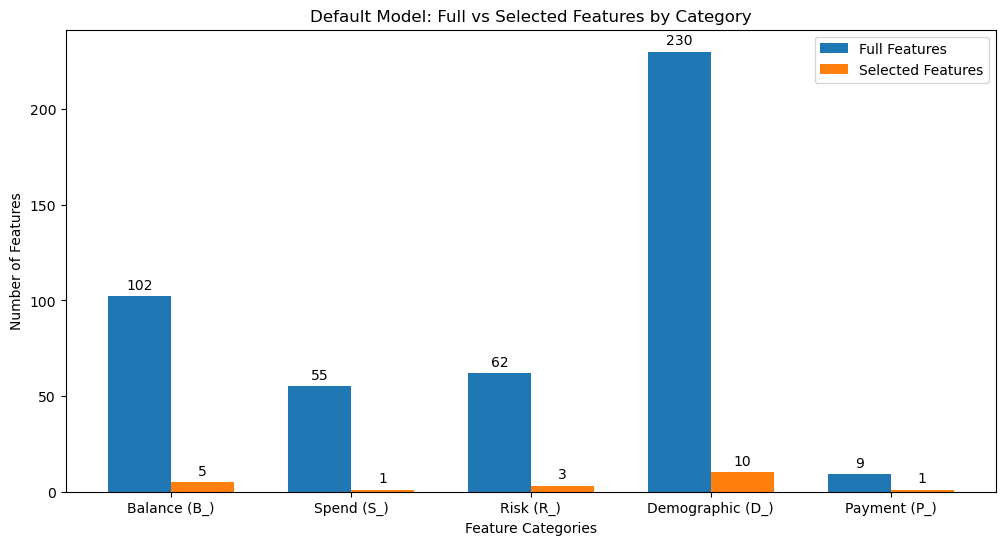

In [319]:
# Extract feature names from the default model datasets
full_features = full_features_default['Feature'].tolist()
selected_features = important_features_default['Feature'].tolist()

# Categorize features based on their prefix (B_, S_, R_, D_, P_)
def categorize_features(feature_list):
    categories = {'Balance (B_)': 0, 'Spend (S_)': 0, 'Risk (R_)': 0, 
                  'Demographic (D_)': 0, 'Payment (P_)': 0}
    for feature in feature_list:
        if feature.startswith('B_'):
            categories['Balance (B_)'] += 1
        elif feature.startswith('S_'):
            categories['Spend (S_)'] += 1
        elif feature.startswith('R_'):
            categories['Risk (R_)'] += 1
        elif feature.startswith('D_'):
            categories['Demographic (D_)'] += 1
        elif feature.startswith('P_'):
            categories['Payment (P_)'] += 1
    return categories

# Get the counts of full and selected features by category
full_feature_counts = categorize_features(full_features)
selected_feature_counts = categorize_features(selected_features)

# Prepare the data for plotting
categories = list(full_feature_counts.keys())
full_counts = list(full_feature_counts.values())
selected_counts = list(selected_feature_counts.values())

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.35  # Width of the bars
x = range(len(categories))  # X-axis positions

# Plot the bars
bars1 = ax.bar([i - width / 2 for i in x], full_counts, width, label='Full Features')
bars2 = ax.bar([i + width / 2 for i in x], selected_counts, width, label='Selected Features')

# Add labels and title
ax.set_xlabel('Feature Categories')
ax.set_ylabel('Number of Features')
ax.set_title('Default Model: Full vs Selected Features by Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Display the counts on top of each bar
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Show the plot
plt.show()


In [318]:
# Extract feature names (assuming the 'Feature' column contains feature names)
feature_names = full_features_default['Feature'].tolist()

# Identify unique feature categories based on prefixes (e.g., B_, S_, R_, D_)
categories = set([name.split('_')[0] for name in feature_names])

# Display the unique categories
print("Unique feature categories:", categories)


Unique feature categories: {'S', 'R', 'D', 'P', 'B'}


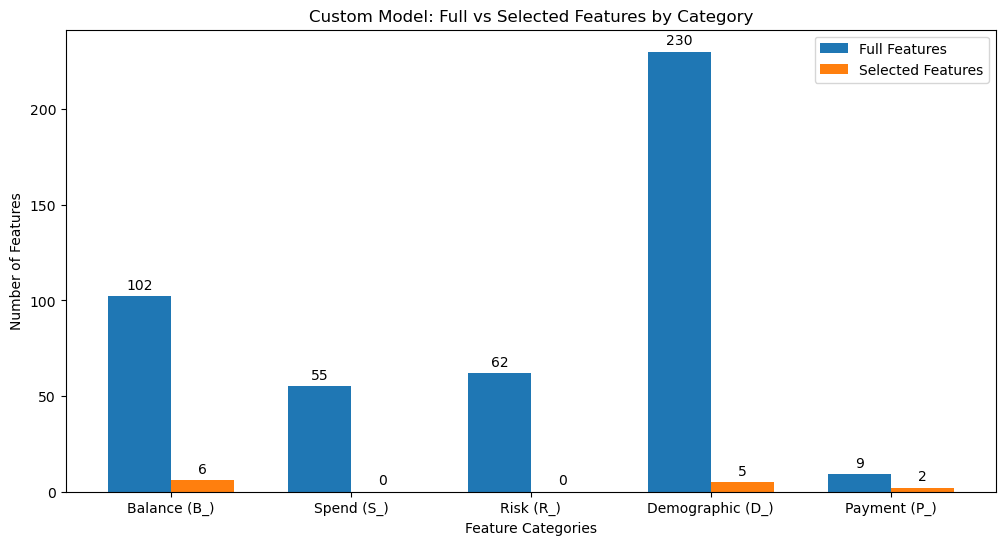

In [320]:
# Extract feature names from the custom model datasets
full_features = full_features_custom['Feature'].tolist()
selected_features = important_features_custom['Feature'].tolist()

# Categorize features based on their prefix (B_, S_, R_, D_, P_)
def categorize_features(feature_list):
    categories = {'Balance (B_)': 0, 'Spend (S_)': 0, 'Risk (R_)': 0, 
                  'Demographic (D_)': 0, 'Payment (P_)': 0}
    for feature in feature_list:
        if feature.startswith('B_'):
            categories['Balance (B_)'] += 1
        elif feature.startswith('S_'):
            categories['Spend (S_)'] += 1
        elif feature.startswith('R_'):
            categories['Risk (R_)'] += 1
        elif feature.startswith('D_'):
            categories['Demographic (D_)'] += 1
        elif feature.startswith('P_'):
            categories['Payment (P_)'] += 1
    return categories

# Get the counts of full and selected features by category
full_feature_counts = categorize_features(full_features)
selected_feature_counts = categorize_features(selected_features)

# Prepare the data for plotting
categories = list(full_feature_counts.keys())
full_counts = list(full_feature_counts.values())
selected_counts = list(selected_feature_counts.values())

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.35  # Width of the bars
x = range(len(categories))  # X-axis positions

# Plot the bars
bars1 = ax.bar([i - width / 2 for i in x], full_counts, width, label='Full Features')
bars2 = ax.bar([i + width / 2 for i in x], selected_counts, width, label='Selected Features')

# Add labels and title
ax.set_xlabel('Feature Categories')
ax.set_ylabel('Number of Features')
ax.set_title('Custom Model: Full vs Selected Features by Category')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Display the counts on top of each bar
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Show the plot
plt.show()


# Slide 6, categories table


In [324]:
import pandas as pd

# Helper function to categorize features
def categorize_features(feature_list):
    categories = {'B_': 0, 'S_': 0, 'R_': 0, 'D_': 0, 'P_': 0}
    for feature in feature_list:
        for key in categories.keys():
            if feature.startswith(key):
                categories[key] += 1
    return categories

# Load full and selected features for both default and custom models
full_default = full_features_default['Feature'].tolist()
selected_default = important_features_default['Feature'].tolist()

full_custom = full_features_custom['Feature'].tolist()
selected_custom = important_features_custom['Feature'].tolist()

# Categorize features for each model
default_full_counts = categorize_features(full_default)
default_selected_counts = categorize_features(selected_default)

custom_full_counts = categorize_features(full_custom)
custom_selected_counts = categorize_features(selected_custom)

# Sum the features across both models (Default + Custom)
total_full_counts = {key: default_full_counts.get(key, 0) + custom_full_counts.get(key, 0)
                     for key in default_full_counts.keys()}
total_selected_counts = {key: default_selected_counts.get(key, 0) + custom_selected_counts.get(key, 0)
                         for key in default_selected_counts.keys()}

# Prepare data for the summary table
summary_data = {
    'Category': ['Balance (B_)', 'Spend (S_)', 'Risk (R_)', 'Demographic (D_)', 'Payment (P_)'],
    '# of Features': [total_full_counts[key] for key in total_full_counts.keys()],
    '# Selected': [total_selected_counts[key] for key in total_selected_counts.keys()]
}

# Create DataFrame for the table
summary_df = pd.DataFrame(summary_data)

# Display the summary table
print(summary_df)

# Optionally save to Excel for presentation purposes
summary_df.to_excel('summarized_Categories_slide6.xlsx', index=False)

print("Summarized feature table saved to 'summarized_feature_summary.xlsx'.")


           Category  # of Features  # Selected
0      Balance (B_)            204          11
1        Spend (S_)            110           1
2         Risk (R_)            124           3
3  Demographic (D_)            460          15
4      Payment (P_)             18           3
Summarized feature table saved to 'summarized_feature_summary.xlsx'.


# Slide 8, The Scatter plots


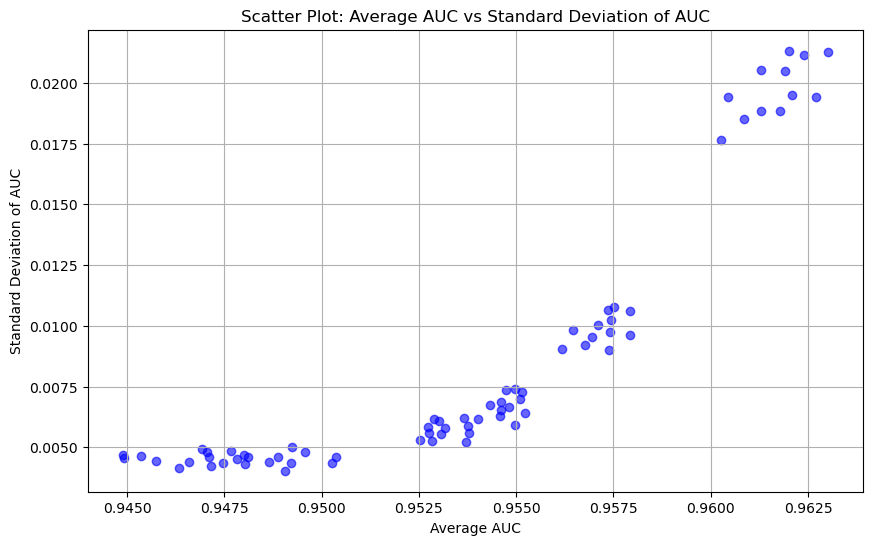

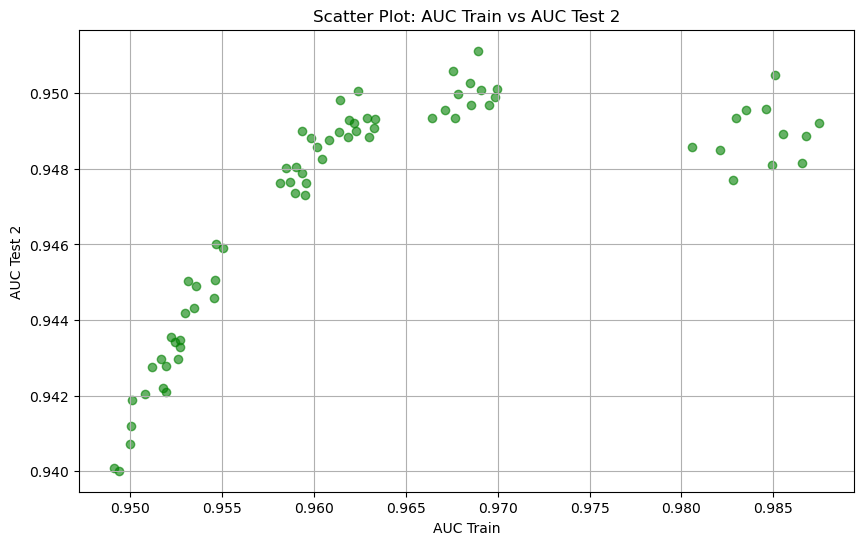

In [325]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the grid search results
grid_search_results = pd.read_csv('grid_search_results.csv')

# Step 1: Calculate Average AUC and Standard Deviation of AUC
grid_search_results['Average_AUC'] = grid_search_results[['AUC Train', 'AUC Test 1', 'AUC Test 2']].mean(axis=1)
grid_search_results['AUC_StdDev'] = grid_search_results[['AUC Train', 'AUC Test 1', 'AUC Test 2']].std(axis=1)

# Step 2: Create Scatter Plot 1 - Average AUC vs Standard Deviation
plt.figure(figsize=(10, 6))
plt.scatter(grid_search_results['Average_AUC'], grid_search_results['AUC_StdDev'], color='b', alpha=0.6)
plt.xlabel('Average AUC')
plt.ylabel('Standard Deviation of AUC')
plt.title('Scatter Plot: Average AUC vs Standard Deviation of AUC')
plt.grid(True)
plt.show()

# Step 3: Create Scatter Plot 2 - AUC Train vs AUC Test 2
plt.figure(figsize=(10, 6))
plt.scatter(grid_search_results['AUC Train'], grid_search_results['AUC Test 2'], color='g', alpha=0.6)
plt.xlabel('AUC Train')
plt.ylabel('AUC Test 2')
plt.title('Scatter Plot: AUC Train vs AUC Test 2')
plt.grid(True)
plt.show()


# Slide #9. XGBoost – Final Model

C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\2512144902.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rank_order = target.groupby(score_bins).mean() * 100  # Default rate in percentage
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\2512144902.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = target.groupby(score_bins).count()  # Number of customers per bin
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\2512144902.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavi

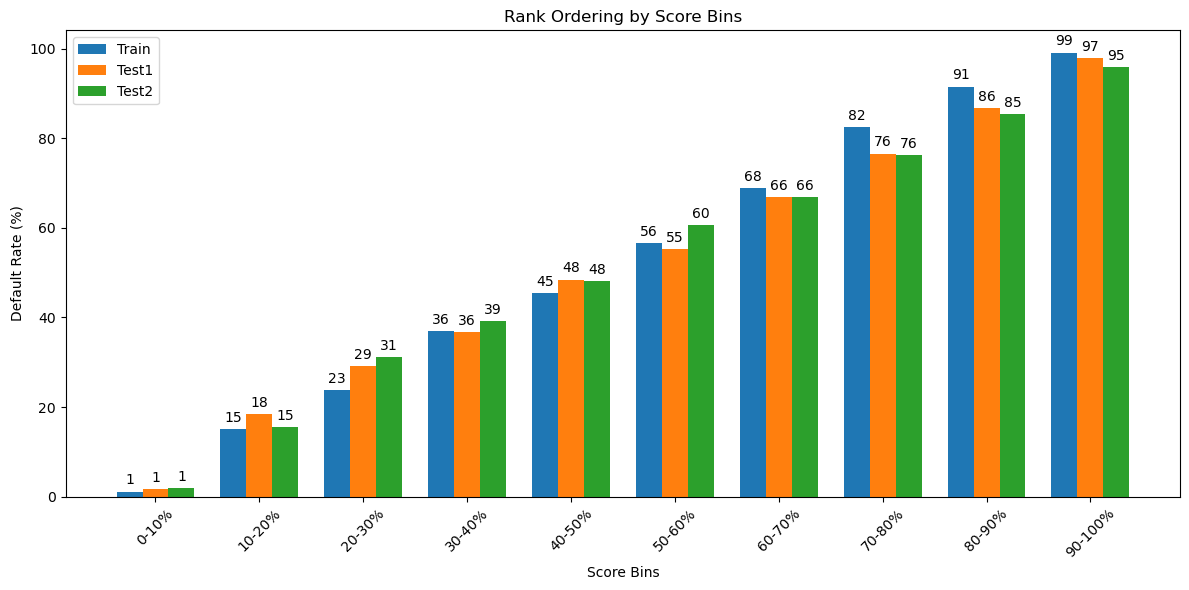

In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define a function to create score bins and calculate default rates
def create_rank_order(probabilities, target, bins=10):
    # Create score bins with pd.cut to ensure proper intervals
    score_bins = pd.cut(probabilities, bins=bins, labels=[f"{i*10}-{(i+1)*10}%" for i in range(bins)])
    
    # Calculate default rate and count for each bin
    rank_order = target.groupby(score_bins).mean() * 100  # Default rate in percentage
    counts = target.groupby(score_bins).count()  # Number of customers per bin
    # Return DataFrame with results
    return pd.DataFrame({'Default Rate (%)': rank_order, 'Count': counts})

# Generate rank order data for Train, Test1, and Test2
train_rank = create_rank_order(train_prob, Y_train)
test1_rank = create_rank_order(test_1_prob, Y_test_1)
test2_rank = create_rank_order(test_2_prob, Y_test_2)

# Prepare data for plotting
bins = train_rank.index
train_default_rates = train_rank['Default Rate (%)'].values
test1_default_rates = test1_rank['Default Rate (%)'].values
test2_default_rates = test2_rank['Default Rate (%)'].values

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.25  # Width of each bar
x = np.arange(len(bins))  # X-axis positions for bins

# Create bars for Train, Test1, and Test2
bars_train = ax.bar(x - width, train_default_rates, width, label='Train')
bars_test1 = ax.bar(x, test1_default_rates, width, label='Test1')
bars_test2 = ax.bar(x + width, test2_default_rates, width, label='Test2')

# Add labels and title
ax.set_xlabel('Score Bins')
ax.set_ylabel('Default Rate (%)')
ax.set_title('Rank Ordering by Score Bins')
ax.set_xticks(x)
ax.set_xticklabels(bins, rotation=45)
ax.legend()

# Display only default rates on top of the bars (without %)
for bars in [bars_train, bars_test1, bars_test2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Vertical offset
                    textcoords='offset points', 
                    ha='center', 
                    va='bottom')

# Show the plot
plt.tight_layout()
plt.show()

In [333]:
train_2_prob

array([0.00881756, 0.00205975, 0.04603172, ..., 0.00288711, 0.1589416 ,
       0.00427496], dtype=float32)

# Slide 10: XGBoost – SHAP Analysis


In [350]:
 # Load the final model and Test 2 data with selected features
import shap
import joblib
import matplotlib.pyplot as plt


xgb_model = joblib.load('final_xgb_model.joblib')  # Ensure correct model is loaded

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_2)


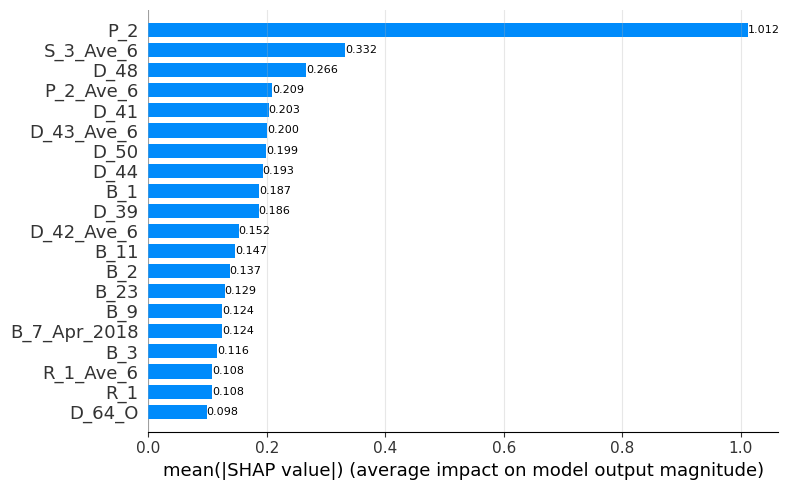

In [357]:
# Summary Bar Plot for SHAP Values
# Adjust the plot size
plt.figure(figsize=(9, 5))

# Create the SHAP summary bar plot
shap.summary_plot(shap_values, X_test_2, plot_type="bar", show=False, plot_size=(8, 5))

# Get current axes and add grid
plt.grid(True, alpha=0.3, axis='x')  # Only horizontal grid lines

# Get the current axis
ax = plt.gca()

# Add values at the end of each bar
bars = ax.patches
feature_importance = np.abs(shap_values).mean(0)
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', 
             ha='left', va='center',
             fontsize=8)

plt.tight_layout()
plt.show()

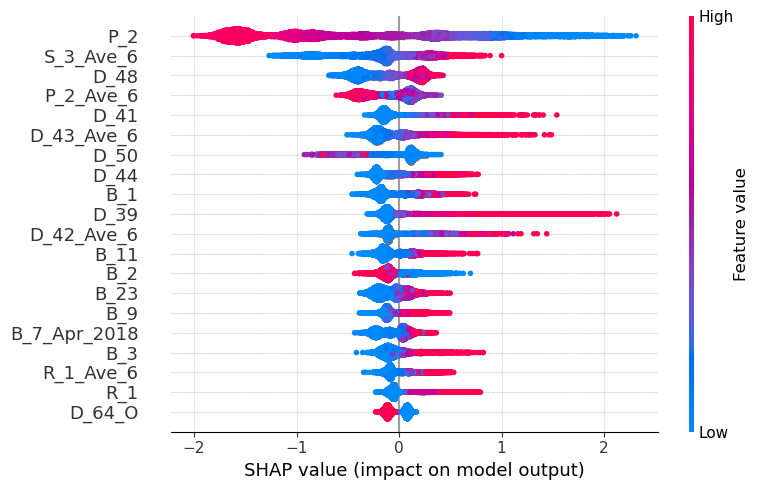

In [360]:
# Beeswarm Plot for SHAP Values 
# Adjust the plot size 
plt.figure(figsize=(7, 3))  # Adjust to preferred size 

# Create Beeswarm Plot
shap.summary_plot(shap_values, X_test_2, plot_type="dot", show=False, plot_size=(8, 5))

# Get current axes and add grid
plt.grid(True, alpha=0.3)  # alpha controls grid transparency

# Show the plot
plt.show()

# Slide #11. XGBoost – SHAP Analysis

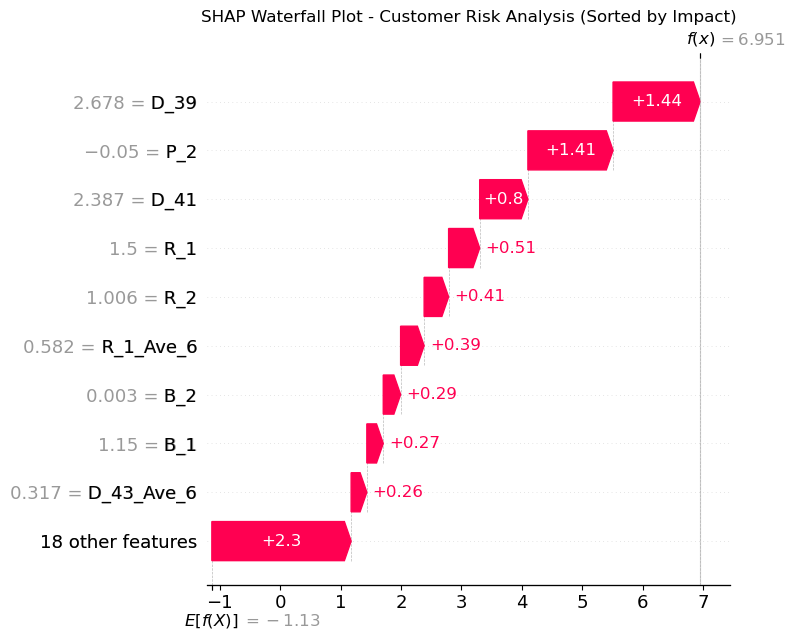

Customer Default Probability: 99.90%
Actual Outcome: Default


In [372]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Create SHAP values for Test 2 sample
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_2)

# Select the observation with the highest predicted probability (high risk)
prediction_probs = xgb_model.predict_proba(X_test_2)[:, 1]
high_risk_idx = np.argmax(prediction_probs)  # Index of the highest risk customer

# Sort the SHAP values by absolute magnitude in descending order
sorted_indices = np.argsort(np.abs(shap_values[high_risk_idx]))[::-1]

# Create a sorted SHAP Explanation object for the waterfall plot
shap_explanation = shap.Explanation(
    values=shap_values[high_risk_idx][sorted_indices],
    base_values=explainer.expected_value,
    data=X_test_2.iloc[high_risk_idx, :].values[sorted_indices],
    feature_names=X_test_2.columns[sorted_indices]
)

# Plot the waterfall plot with the sorted SHAP values
plt.figure(figsize=(4, 2))  # Changed from (7, 4) to (5, 3)
shap.plots.waterfall(shap_explanation, show=False)
plt.title('SHAP Waterfall Plot - Customer Risk Analysis (Sorted by Impact)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print additional information about the customer
print(f"Customer Default Probability: {prediction_probs[high_risk_idx]:.2%}")
print(f"Actual Outcome: {'Default' if Y_test_2.iloc[high_risk_idx] == 1 else 'Non-Default'}")

# Slide #12. Neural Network – Data Processing

In [379]:
# just process

# Slide #13. Neural Network - Grid Search

What to Include on Slide #12 (Neural Network – Data Processing):
Explanation of Data Preparation:

Why data preparation is essential for Neural Networks (NNs), emphasizing:
NNs are sensitive to input scaling and feature distributions.
The importance of clean, normalized data for convergence and performance.
Key Steps in Data Processing:

Handling Missing Values:
Mention whether you imputed, removed, or replaced missing values (if any) for the NN.
Feature Scaling/Normalization:
Explain how you applied Standardization or Min-Max Scaling to ensure features have consistent ranges.
You can mention, for example:
python
Copy code
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
Encoding Categorical Variables:
If applicable, explain any One-Hot Encoding you performed.
Mention why NNs prefer numeric inputs only and how this affected data preparation.
Train-Test Split for Neural Network:

How you divided the data into training, validation, and test sets.
Example split: 70% train, 15% validation, 15% test.
If you used stratified sampling, you can mention that as well.
Table for Data Summary (Optional):

Include a summary table showing:

Number of features before and after scaling/encoding.
Train, validation, and test sizes.
Summary statistics like mean, min, max, etc., after scaling.
Example:

Dataset	# Samples	# Features	Processing Applied
Train	60,000	50	Scaled, Encoded
Validation	12,500	50	Scaled, Encoded
Test	12,500	50	Scaled, Encoded
Add Code Blocks (Optional):

If needed, include code snippets (short, easy to follow) to demonstrate scaling, encoding, and data split.
Summary:
This slide focuses on explaining the preprocessing steps required for the Neural Network to run effectively. You can use tables, code snippets, and brief explanations to make it clear and easy to follow. The main takeaway is to show how the data was processed, normalized, and split before passing it to the NN model.

# Slide #14. Neural Network - Grid Search

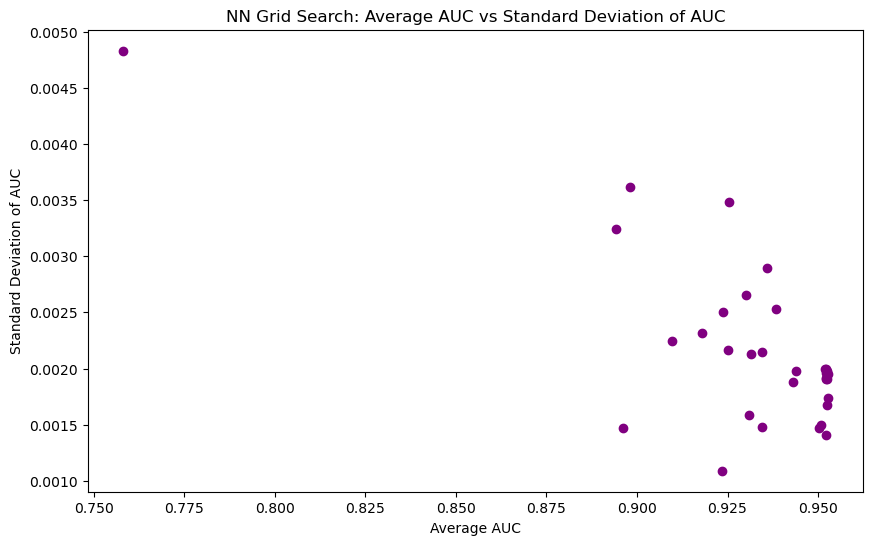

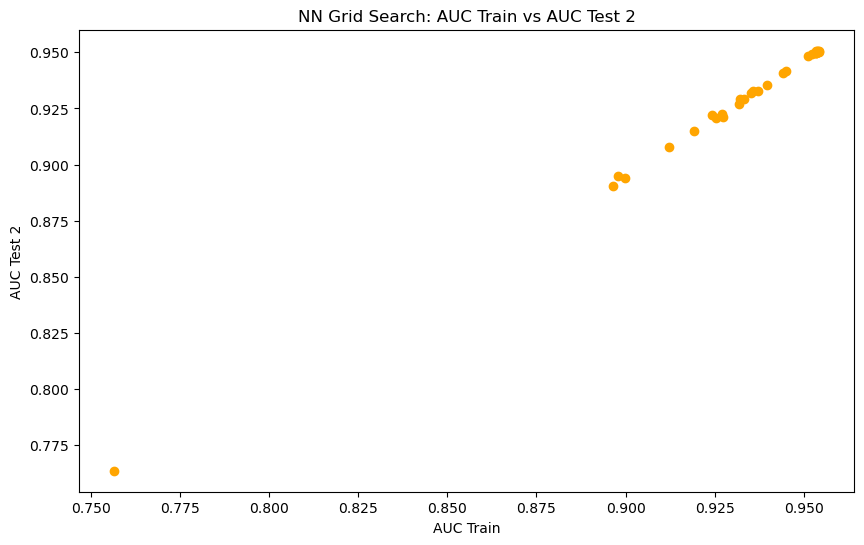

In [326]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Neural Network Grid Search results
nn_grid_results = pd.read_csv('nn_grid_search_results.csv')

# Calculate Average AUC and Standard Deviation across Train, Test1, and Test2
nn_grid_results['Average AUC'] = nn_grid_results[['AUC Train', 'AUC Test 1', 'AUC Test 2']].mean(axis=1)
nn_grid_results['AUC Std Dev'] = nn_grid_results[['AUC Train', 'AUC Test 1', 'AUC Test 2']].std(axis=1)

# Scatter Plot 1: Average AUC vs Standard Deviation of AUC
plt.figure(figsize=(10, 6))
plt.scatter(nn_grid_results['Average AUC'], nn_grid_results['AUC Std Dev'], color='purple')
plt.xlabel('Average AUC')
plt.ylabel('Standard Deviation of AUC')
plt.title('NN Grid Search: Average AUC vs Standard Deviation of AUC')
plt.show()

# Scatter Plot 2: AUC Train vs AUC Test 2
plt.figure(figsize=(10, 6))
plt.scatter(nn_grid_results['AUC Train'], nn_grid_results['AUC Test 2'], color='orange')
plt.xlabel('AUC Train')
plt.ylabel('AUC Test 2')
plt.title('NN Grid Search: AUC Train vs AUC Test 2')
plt.show()


# Slide #15. Neural Network – Final Model

In [382]:
import tensorflow as tf  # For loading the Keras model

# Load the saved Neural Network model
final_nn_model = tf.keras.models.load_model('final_nn_model.keras')

# Generate predicted probabilities for Train, Test1, and Test2
train_prob_nn = final_nn_model.predict(X_train)
test_1_prob_nn = final_nn_model.predict(X_test_1)
test_2_prob_nn = final_nn_model.predict(X_test_2)

# Save the predicted probabilities as .npy files
import numpy as np

np.save('train_prob_nn.npy', train_prob_nn)
np.save('test_1_prob_nn.npy', test_1_prob_nn)
np.save('test_2_prob_nn.npy', test_2_prob_nn)


2008/2008 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
431/431 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [406]:
test_1_prob_nn

array([0.27480015, 0.27480015, 0.27480015, ..., 0.27480015, 0.27480015,
       0.27480015], dtype=float32)

C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3758519782.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = actuals.groupby(score_bins).mean() * 100
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3758519782.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  default_rates = actuals.groupby(score_bins).mean() * 100
C:\Users\mourl\AppData\Local\Temp\ipykernel_32100\3758519782.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default

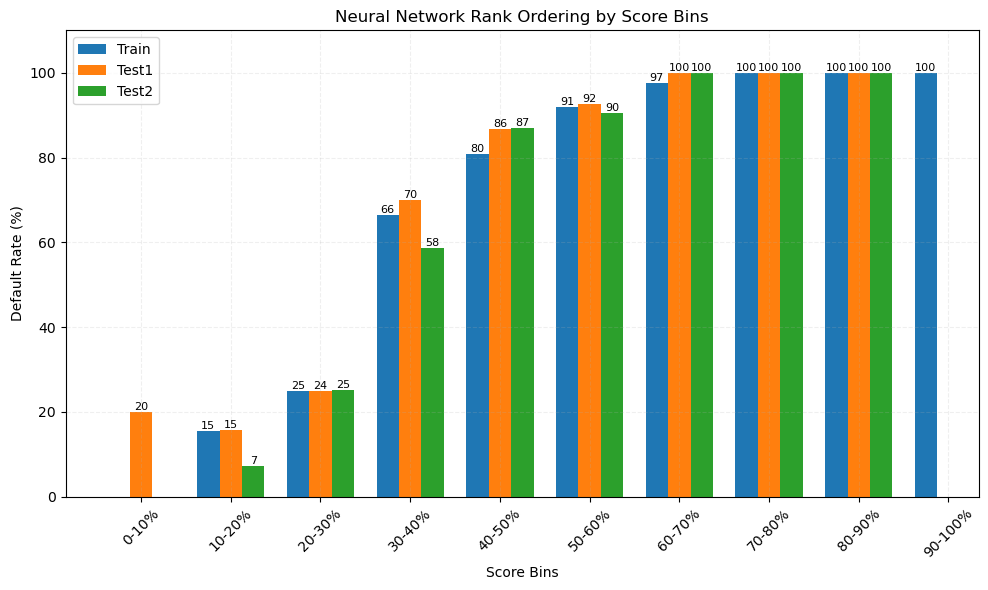

In [387]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def rank_order_by_bins(probabilities, actuals, bins):
   bin_labels = [f"{int(bins[i]*100)}-{int(bins[i+1]*100)}%" for i in range(len(bins)-1)]
   score_bins = pd.cut(probabilities, bins=bins, labels=bin_labels, include_lowest=True)
   default_rates = actuals.groupby(score_bins).mean() * 100
   counts = score_bins.value_counts()
   return pd.DataFrame({'Default Rate (%)': default_rates, 'Count': counts})

# Define bins
bins = np.linspace(0, 1, 11)

# Calculate rank ordering
train_rank_order = rank_order_by_bins(train_prob_nn, Y_train, bins)
test1_rank_order = rank_order_by_bins(test_1_prob_nn, Y_test_1, bins)
test2_rank_order = rank_order_by_bins(test_2_prob_nn, Y_test_2, bins)

# Plotting
plt.figure(figsize=(10, 6))

width = 0.25
x = np.arange(len(bins) - 1)

# Plot bars
bars1 = plt.bar(x - width, train_rank_order['Default Rate (%)'], width, label='Train')
bars2 = plt.bar(x, test1_rank_order['Default Rate (%)'], width, label='Test1')
bars3 = plt.bar(x + width, test2_rank_order['Default Rate (%)'], width, label='Test2')

# Add value labels on top of bars
def autolabel(bars):
   for bar in bars:
       height = bar.get_height()
       if height > 0:  # Only add label if bar exists
           plt.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',  # Removed % sign
                   ha='center', va='bottom', fontsize=8)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

plt.xlabel('Score Bins')
plt.ylabel('Default Rate (%)')
plt.title('Neural Network Rank Ordering by Score Bins')
plt.xticks(x, train_rank_order.index, rotation=45)
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(loc='upper left')
plt.ylim(0, 110)  # Set y-axis limit to 110

plt.tight_layout()
plt.show()

# Slide #16. Final Model. 

If we look back, XGBoost seems like the better candidate because:

More consistent rank ordering performance across datasets.

Higher AUC with less variance (as seen in scatter plots).

Better interpretability with SHAP plots available for feature importance and individual predictions

Summary of What to Do:

Choose the final model (either XGBoost or Neural Network).

Explain why it was chosen (e.g., better rank ordering, higher AUC, better generalization).

Include supporting graphs: Bar charts of rank ordering and AUC metrics across Train, Test1, and Test2.

Discuss interpretability if relevant (for example, XGBoost with SHAP analysis).

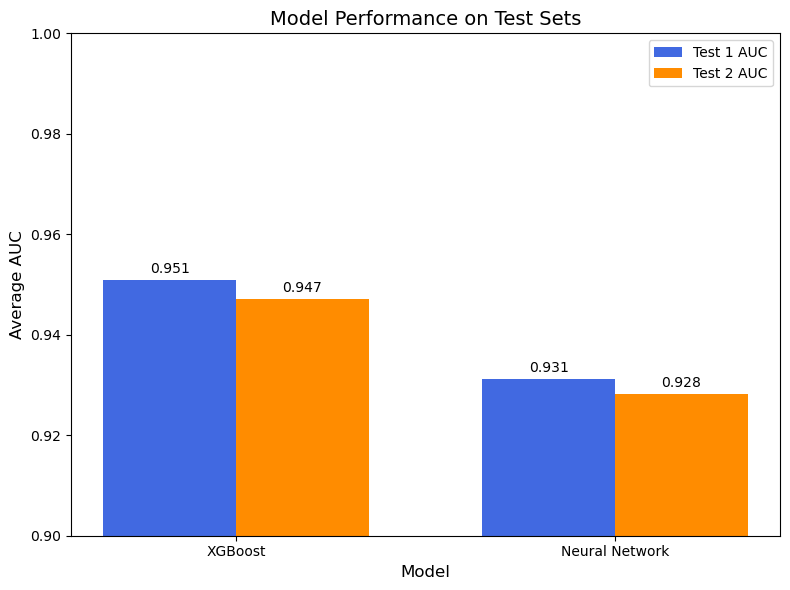

In [393]:
import pandas as pd
import matplotlib.pyplot as plt

# Load grid search results for both models
xgb_results = pd.read_csv('grid_search_results.csv')
nn_results = pd.read_csv('nn_grid_search_results.csv')

# Calculate average AUC for Test1 and Test2 for both models
xgb_avg_auc_test1 = xgb_results['AUC Test 1'].mean()
xgb_avg_auc_test2 = xgb_results['AUC Test 2'].mean()
nn_avg_auc_test1 = nn_results['AUC Test 1'].mean()
nn_avg_auc_test2 = nn_results['AUC Test 2'].mean()

# Prepare data for plotting
models = ['XGBoost', 'Neural Network']
avg_auc_test1 = [xgb_avg_auc_test1, nn_avg_auc_test1]
avg_auc_test2 = [xgb_avg_auc_test2, nn_avg_auc_test2]

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
width = 0.35  # Width of the bars
x = range(len(models))  # X-axis positions

# Plot Test1 and Test2 AUCs side by side
bars1 = ax.bar([i - width/2 for i in x], avg_auc_test1, width, color='royalblue', label='Test 1 AUC')
bars2 = ax.bar([i + width/2 for i in x], avg_auc_test2, width, color='darkorange', label='Test 2 AUC')

# Add labels and title
ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Average AUC', fontsize=12)
ax.set_title('Model Performance on Test Sets', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0.9, 1)  # Focus on the AUC range

# Move legend to the top-right corner
ax.legend(loc='upper right', frameon=True)

# Display the AUC values on top of the bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Slide #17. Strategy

In [408]:
import pandas as pd

# Initialize a list to store the combined results
all_results = []

# Define the thresholds to evaluate
thresholds = [round(x, 2) for x in np.arange(0.1, 1.1, 0.1)]  # Adjusted to match the table

# Loop over thresholds and calculate default rate and revenue for Train, Test1, and Test2
for threshold in thresholds:
    # Train results
    train_default_rate, train_revenue = calculate_default_rate_and_revenue(
        Y_train, train_prob, X_train['B_23'], X_train['S_3_Ave_6'], threshold
    )
    train_total = (train_prob < threshold).sum()

    # Test1 results
    test_1_default_rate, test_1_revenue = calculate_default_rate_and_revenue(
        Y_test_1, test_1_prob, X_test_1['B_23'], X_test_1['S_3_Ave_6'], threshold
    )
    test_1_total = (test_1_prob < threshold).sum()

    # Test2 results
    test_2_default_rate, test_2_revenue = calculate_default_rate_and_revenue(
        Y_test_2, test_2_prob, X_test_2['B_23'], X_test_2['S_3_Ave_6'], threshold
    )
    test_2_total = (test_2_prob < threshold).sum()

    # Append the results for the current threshold
    all_results.append({
        'Threshold': threshold,
        'Train #Total': train_total,
        'Train Default Rate': train_default_rate,
        'Train Revenue': train_revenue,
        'Test1 #Total': test_1_total,
        'Test1 Default Rate': test_1_default_rate,
        'Test1 Revenue': test_1_revenue,
        'Test2 #Total': test_2_total,
        'Test2 Default Rate': test_2_default_rate,
        'Test2 Revenue': test_2_revenue
    })

# Convert the combined results into a DataFrame
all_results_df = pd.DataFrame(all_results)

# Save the results to an Excel file
all_results_df.to_excel('Results_Table_Slide17.xlsx', index=False)

# Alternatively, save as a CSV file if needed
# all_results_df.to_csv('strategy_results.csv', index=False)
